This notebook examines the results from three modifications to the previous MESA inlists

* a new set of wind models
* a new stopping condition to avoid runaway critically rotating stars
* tracking the chemical mixing timescale

In [1]:
# nb_id is used to identify this notebook's output files (i.e., figures) if there are any
# it should match the first two digits in the notebook's title
nb_id = 10

### Prelude

In [2]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import astropy.units as u
import astropy.constants as ct
from astropy.cosmology import WMAP9
from scipy.signal import find_peaks
from scipy.integrate import simpson

import mesa_reader as mr
import mesaPlot as mp

import sys
sys.path.append('..')
from src.constants import (Z_SUN, MASS_U, PERIOD_U, AGE_U, SMA_U, RADIUS_U, TEMP_U, LUMINOSITY_U, 
                           T_H)
from src.star import (eggleton_rl1_radius, marchant_l2_radius, a_from_p, p_from_a, tau_kh, fix_unit,
                      ToutMassLuminosityRelation, ToutMassRadiusRelation, 
                      HurleyMassLuminosityRelation, HurleyMassRadiusRelation)


/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

In [3]:
ROOT = Path.cwd().parent
FIGURE_FOLDER = Path(f'./output/nb{nb_id}/figures')
FIGURE_FOLDER.mkdir(parents=True, exist_ok=True)

In [4]:
plt.style.use('./plotstyle.mplstyle')

In [5]:
def tau_es1(m, r, tau_kh, omega):
    m = fix_unit(m, MASS_U)
    r = fix_unit(r, RADIUS_U)
    tau_kh = fix_unit(tau_kh, u.yr)
    omega *= u.s**-1
    tau_es = tau_kh * ct.G * m / (omega**2 * r**3)   
    return tau_es.to(u.yr).value
    

In [6]:
def savefig(fig, fname):
    fname = f'nb{nb_id}_{fname}'
    plt.savefig(FIGURE_FOLDER/(fname+'.png'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.pdf'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.eps'), bbox_inches='tight')

### References

Gottlieb, O., Renzo, M., Metzger, B. D., Goldberg, J. A. & Cantiello, M., *She's got her mother's hair: end-to-end collapsar simulations unveil the origin of black holes' magnetic field*, 2024, [arXiv:2407.16745](https://ui.adsabs.harvard.edu/abs/2024arXiv240716745G/abstract)  
Nugis, T. & Lamers, H. J. G. L. M., *Mass-loss rates of Wolf-Rayet stars as a function of stellar parameters*, 2000, [A&A 360, 227](https://ui.adsabs.harvard.edu/abs/2000A%26A...360..227N/abstract)  
Vink, J. S., de Koter, A. & Lamers, H. J. G. L. M., *New theoretical mass-loss rates of O and B Stars*, 2000, [A&A, 362, 295](https://ui.adsabs.harvard.edu/abs/2000A%26A...362..295V/abstract)

### Definitions

In [7]:
mix_dict = dict(
    radiative=-1,
    none=0,
    convective=1,
    overshoot=2,
    semiconvective=3,
    thermohaline=4,
    rotation=5,
    rayleigh_taylor=6,
    minimum=7,
    anonymous=8,
    leftover=9,
    phase_sep=10
    )
mix_dict = {v: k for k, v in mix_dict.items()}

In [8]:
def get_model_dict(grid_folder):
    d = dict()
    for model_folder in grid_folder.glob('m*_w*'):
        if model_folder.suffix == '.log':
            continue
        m, w = model_folder.name.replace('d', 'e').split('_')        
        m = f'{float(m.lstrip("m")):.1f}'
        w = float(w.lstrip('w'))
        p = 2*np.pi / w / (60*60*24)
        p = f'{p:.2f}'
        if m not in d.keys():
            d[m] = dict()
        d[m][p] = model_folder
    return d

In [9]:
def monitor(w, h, axes, c, col_indices=[0, 1, 2, 3, 4, 5, 6]):
    #fig, axes = plt.subplots(1, 7, figsize=(36, 4), sharex=True)
    #fig.subplots_adjust(wspace=0.5)

    omg_ax, wct_ax, vrt_ax, mss_ax, rad_ax, lum_ax, he4_ax = col_indices 

    axes[omg_ax].plot(h.star_age/1e6, h.surf_avg_v_rot/(2*np.pi*h.radius*u.Rsun.to(u.km)/(2*np.pi)), lw=1, c=c)     
    axes[vrt_ax].plot(h.star_age/1e6, h.surf_avg_v_rot, lw=1, c=c)     
    axes[rad_ax].plot(h.star_age/1e6, h.radius, lw=1, c=c)    
    axes[wct_ax].plot(h.star_age/1e6, h.surf_avg_omega_div_omega_crit, lw=1, c=c)        
    axes[mss_ax].plot(h.star_age/1e6, h.star_mass, lw=1, c=c)    
    axes[lum_ax].plot(h.star_age/1e6, h.log_L, lw=1, c=c)    
    axes[he4_ax].plot(h.star_age/1e6, h.surface_he4, lw=1, c=c)    
    axes[he4_ax].plot(h.star_age/1e6, h.center_h1, lw=1, c=c, ls='--') 
    
    i_critrot_peaks = find_peaks(h.surf_avg_omega_div_omega_crit, height=1, distance=100, prominence=0.1)[0]
    t_critrot_peaks= h.star_age[i_critrot_peaks]/1e6
    for t in t_critrot_peaks:
        # don't plot peaks (too many in one panel)
        continue
        for ax in axes:
            y0, y1 = ax.get_ylim()
            ax.vlines(t, 0, y1, lw=1, color='k', ls='-')
            try:
                ax.vlines(h.star_age[1500]/1e6, 0, y1, lw=1, color='k', ls='--')
            except IndexError:
                pass
            ax.set_ylim(y0, y1)
            
    #axes[omg_ax].set_ylabel('$\\Omega$')
    #axes[vrt_ax].set_ylabel('$v_\\mathrm{rot}/\\mathrm{km}\\,\\mathrm{s}^{-1}$')
    #axes[rad_ax].set_ylabel('$R/\\mathrm{R}_\\odot$')
    #axes[wct_ax].set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')
    #axes[mss_ax].set_ylabel('$M/\\mathrm{M}_\\odot$')
    #axes[lum_ax].set_ylabel('$L/\\mathrm{L}_\\odot$')
    #axes[he4_ax].set_ylabel('S.He4 / C. H1')
    
    if h.center_h1[-1] < 1e-7:
        status = 'DONE'
    else:
        status = 'RUNNING'
        
    p = 2 * np.pi / float(w) / (24*60*60)
    handle = Line2D((-1, -1), (-1, -1), linestyle='-', color=c, 
                    label=f'${p:.2f}\\,\\mathrm{{d}}$ ({np.log10(h.center_h1[-1]):.1f}, {len(h.star_age)} steps)')
    #axes[3].text(0.5, 1.1, f'$m={m:.1f}\\,\\mathrm{{M}}_\\odot, P={p:.2f}\\,\\mathrm{{d}}, \\Omega={w:.1e}\\,\\mathrm{{rad}}\\,\\mathrm{{s}}^{{-1}},$ {len(h.star_age)} steps ({status})', 
    #             rotation=0, va='center', ha='right', fontsize=28, transform=axes[3].transAxes)   
    
    return axes, handle

### Analysis

In [10]:
GRID_FOLDER1 = ROOT/'mesa/sse_newmodels_test/02_gridnewfix_m65_var_p_test'
GRID_FOLDER2 = ROOT/'mesa/sse_newmodels_test/06_resolution_test_m65grid_0.75mesh'
GRID_FOLDER3 = ROOT/'mesa/sse_newmodels_test/03_resolution_test_m65grid_0.5mesh'
GRID_FOLDER32 = ROOT/'mesa/sse_newmodels_test/07_resolution_test_m65grid_0.5mesh_MathieuMeshOff'
GRID_FOLDER4 = ROOT/'mesa/sse_newmodels_test/04_resolution_test_m65grid_0.25mesh'
GRID_FOLDER5 = ROOT/'mesa/sse_newmodels_test/05_resolution_test_m65grid_0.125mesh'

In [11]:
model_dict1 = get_model_dict(GRID_FOLDER1)
model_dict2 = get_model_dict(GRID_FOLDER2)
model_dict3 = get_model_dict(GRID_FOLDER3)
model_dict32 = get_model_dict(GRID_FOLDER32)
model_dict4 = get_model_dict(GRID_FOLDER4)
model_dict5 = get_model_dict(GRID_FOLDER5)

In [12]:
def mesareader_operator(expression):
    operations = ['+', '-', '*', '/', '(', ')']
    
    mr_expression = ''
    attr = ''
    char_i = 0
    while char_i < len(expression):
        char = expression[char_i]
        if char not in operations:
            mr_expression += f'h.__getattr__("{char}'
        else:
            mr_expression += f'{char}h.__getattr__("'
        char_i += 1
        char = expression[char_i]
        while char not in operations+['']:
            attr += char
            char_i += 1
            try:
                char = expression[char_i]
            except IndexError:
                char = ''
        attr = f'{attr}"){char}'
        mr_expression += attr
        attr = ''
        char_i += 1
            
    return mr_expression

In [13]:
def history_plot(ax, model_dict_list, model_styles, model_labels, x, y, invert_xaxis, invert_yaxis, title=False,
                 label_period=True):
    base_dict = model_dict_list[0]
    all_paths = [base_dict[k1][k2] for k1 in base_dict.keys() for k2 in base_dict[k1].keys()] 
    
    _c = 1
    handles = []
    for m_key in base_dict.keys():
        base_p_dict = base_dict[m_key]
        p_keys_sort = np.argsort(np.float64(np.array(list(base_p_dict.keys()))))
        p_keys = np.array(list(base_p_dict.keys()))[p_keys_sort][1:]
        m = float(m_key)
        for p_key in p_keys:
            p = float(p_key)
            c = cm.jet(_c/len(all_paths))
            if label_period:
                label = f'${p:.2f}\\,\\mathrm{{d}}$'
            else:
                label = None
            handles.append(Line2D([], [], ls='-', color=c, label=label))
                        
            for model_dict, ls in zip(model_dict_list, model_styles):
                model_path = model_dict[m_key][p_key]    
                h = mr.MesaData(str(model_path/'LOGS/history.data'))
                ax.plot(h.__getattr__(x), h.__getattr__(y), ls=ls, color=c, lw=1)
                
            _c += 1
                
    if invert_xaxis:
        ax.invert_xaxis()
    if invert_yaxis:
        ax.invert_yaxis()
    
    if title:
        ax.set_title(model_labels[0], fontsize=20)
    else:
        for ls, label in zip(model_styles, model_labels):
            handles.append(Line2D([], [], color='k', ls=ls, label=label))
    ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))
    
    return ax

In [14]:
def history_plot(ax, model_dict_list, model_styles, model_labels, x, y, invert_xaxis, invert_yaxis, title=False,
                 label_period=True):
    base_dict = model_dict_list[0]
    all_paths = [base_dict[k1][k2] for k1 in base_dict.keys() for k2 in base_dict[k1].keys()] 
    
    _c = 1
    handles = []
    for m_key in base_dict.keys():
        base_p_dict = base_dict[m_key]
        p_keys_sort = np.argsort(np.float64(np.array(list(base_p_dict.keys()))))
        p_keys = np.array(list(base_p_dict.keys()))[p_keys_sort][1:]
        m = float(m_key)
        for p_key in p_keys:
            p = float(p_key)
            c = cm.jet(_c/len(all_paths))
            if label_period:
                label = f'${p:.2f}\\,\\mathrm{{d}}$'
            else:
                label = None
            handles.append(Line2D([], [], ls='-', color=c, label=label))
                        
            for model_dict, ls in zip(model_dict_list, model_styles):
                model_path = model_dict[m_key][p_key]    
                h = mr.MesaData(str(model_path/'LOGS/history.data'))
                x_data = eval(mesareader_operator(x))
                y_data = eval(mesareader_operator(y))
                ax.plot(x_data, y_data, ls=ls, color=c, lw=1)
                
            _c += 1
                
    if invert_xaxis:
        ax.invert_xaxis()
    if invert_yaxis:
        ax.invert_yaxis()
    
    if title:
        ax.set_title(model_labels[0], fontsize=20)
    else:
        for ls, label in zip(model_styles, model_labels):
            handles.append(Line2D([], [], color='k', ls=ls, label=label))
    ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))
    
    return ax

## History plots

### HR Diagram

#### All periods per resolution

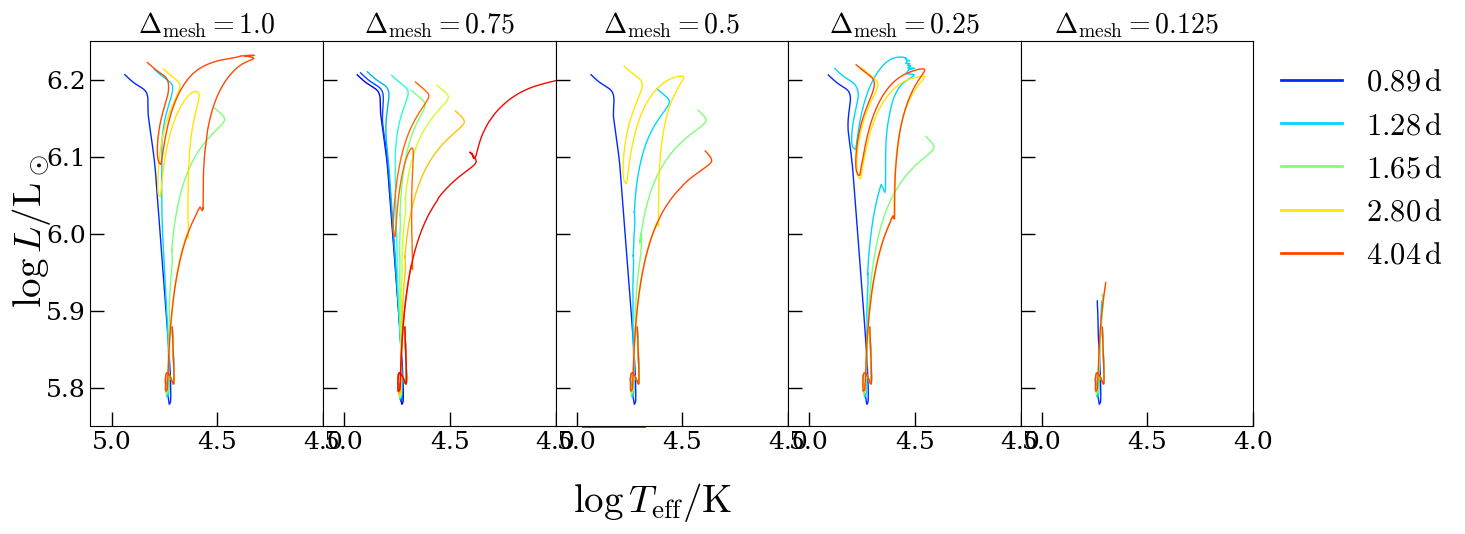

In [15]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0)

model_dict_list = [model_dict1, model_dict2, model_dict3, model_dict4, model_dict5]
model_labels = [
    '$\\Delta_\\mathrm{mesh}=1.0$',
    '$\\Delta_\\mathrm{mesh}=0.75$',
    '$\\Delta_\\mathrm{mesh}=0.5$',
    '$\\Delta_\\mathrm{mesh}=0.25$',
    '$\\Delta_\\mathrm{mesh}=0.125$'
]
model_styles = len(model_dict_list) * ['-']

for i, (ax, model_dict, model_label, model_style) in enumerate(zip(axes, model_dict_list, model_labels, model_styles)):
    if i == len(model_dict_list)-1:
        label_period = True
    else:
        label_period = False
    settings = dict(
        x='log_Teff',
        y='log_L',
        invert_xaxis=True,
        invert_yaxis=False,
        model_dict_list=[model_dict],
        model_styles=[model_style],
        model_labels=[model_label],
        title=True,
        label_period=label_period
    )
    history_plot(ax, **settings)
    
for ax in axes:
    ax.tick_params(direction='in')
    ax.set_ylim(5.75, 6.25)
    ax.set_xlim(5.1, 4)

fig.text(0.5, 0, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', va='top', ha='center', transform=fig.transFigure)
fig.text(0.1, 0.5, '$\\log L/\\mathrm{L}_\\odot$', rotation=90, va='center', ha='right', transform=fig.transFigure)

savefig(fig, 'hr_res_panels')   

#### One resolution, all periods

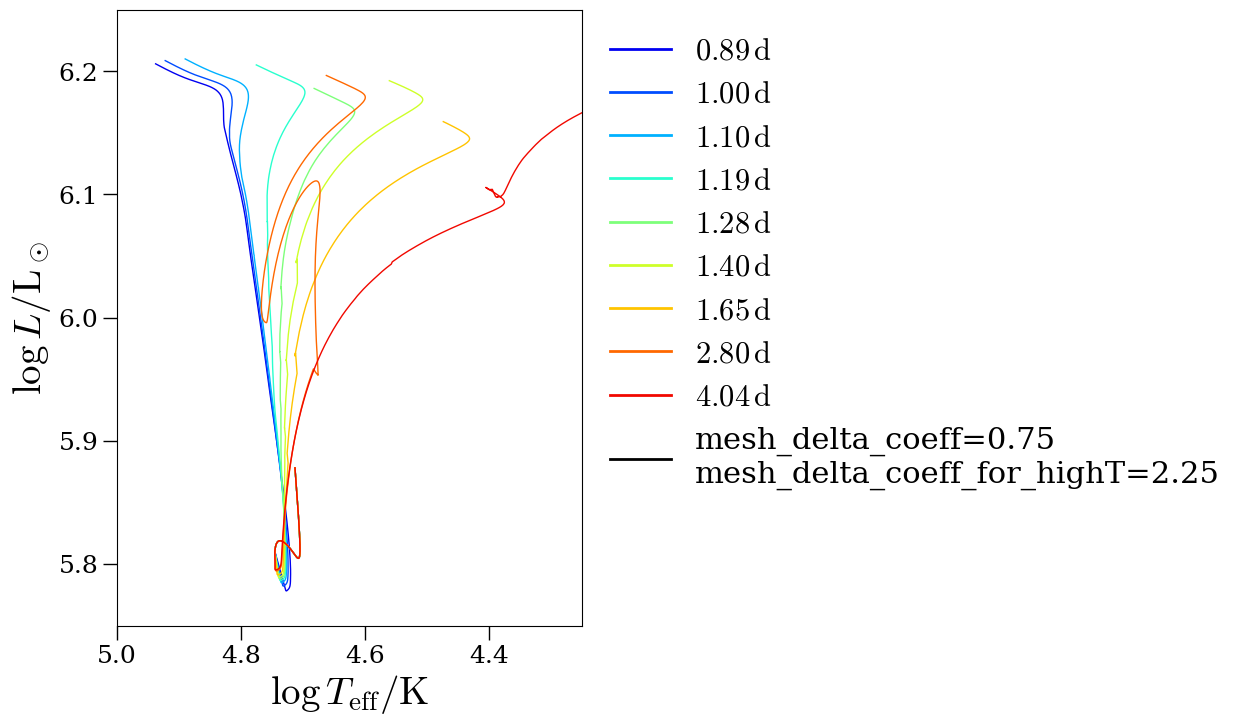

In [134]:
fig, ax = plt.subplots(figsize=(6, 8))
settings = dict(
    x='log_Teff',
    y='log_L',
    invert_xaxis=True,
    invert_yaxis=False,
    model_dict_list=[model_dict2],
    model_styles=['-'],
    model_labels=[
        'mesh_delta_coeff=0.75\nmesh_delta_coeff_for_highT=2.25'
    ],
)

ax = history_plot(ax, **settings)

ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
ax.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')
ax.set_xlim(5, 4.25)
ax.set_ylim(5.75, 6.25)

savefig(fig, 'hr_mesh075_allp')

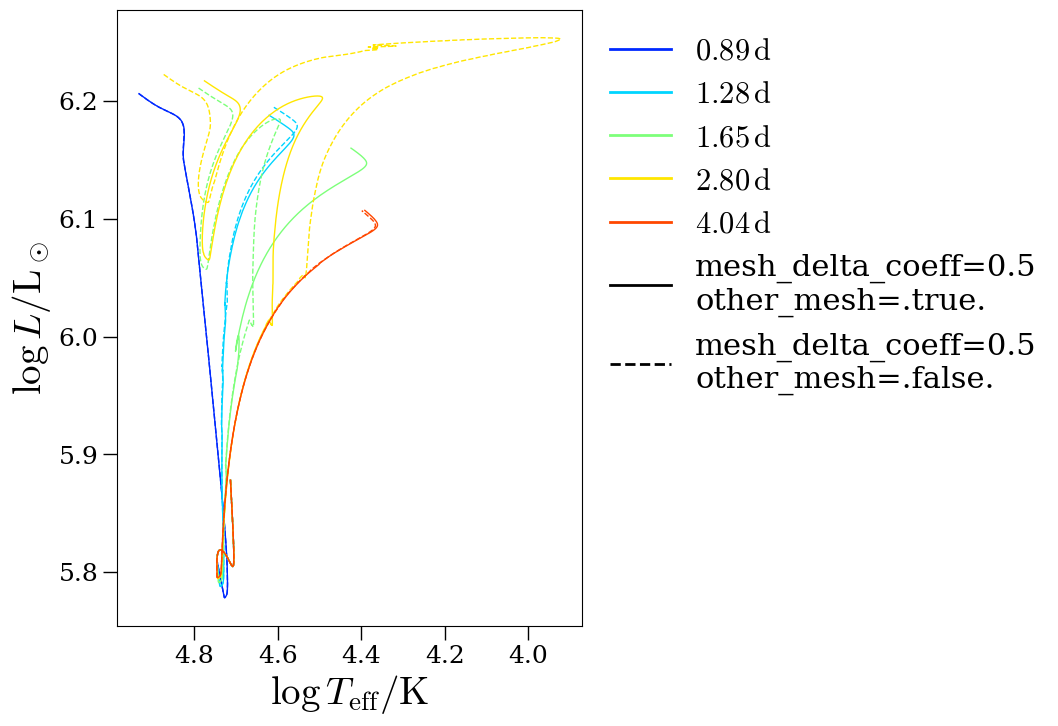

In [135]:
fig, ax = plt.subplots(figsize=(6, 8))
settings = dict(
    x='log_Teff',
    y='log_L',
    invert_xaxis=True,
    invert_yaxis=False,
    model_dict_list=[model_dict3, model_dict32],
    model_styles=['-', '--'],
    model_labels=[
        'mesh_delta_coeff=0.5\nother_mesh=.true.',
        'mesh_delta_coeff=0.5\nother_mesh=.false.',
    ],
)

ax = history_plot(ax, **settings)

ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
ax.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')
#ax.set_xlim(5, 4.25)
#ax.set_ylim(5.75, 6.25)

savefig(fig, 'hr_othermesh_onoff')

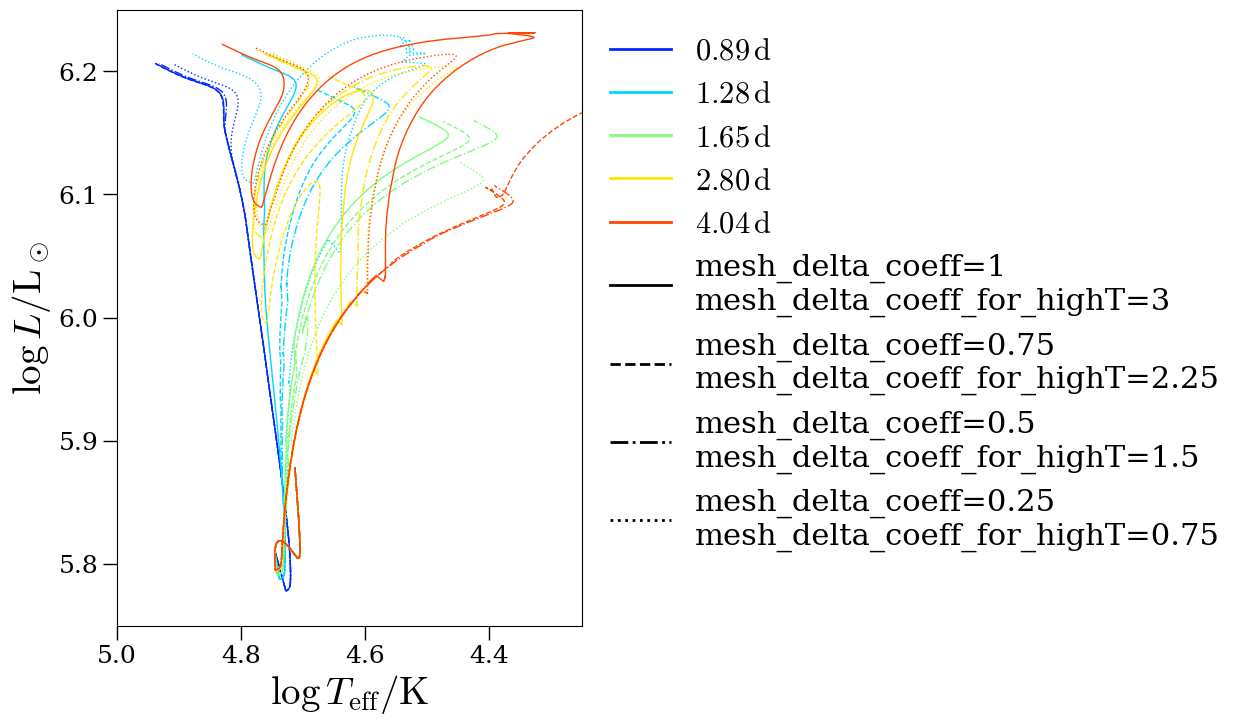

In [136]:
fig, ax = plt.subplots(figsize=(6, 8))
settings = dict(
    x='log_Teff',
    y='log_L',
    invert_xaxis=True,
    invert_yaxis=False,
    model_dict_list=[model_dict1, model_dict2, model_dict3, model_dict4],
    model_styles=['-', '--', '-.', ':'],
    model_labels=[
        'mesh_delta_coeff=1\nmesh_delta_coeff_for_highT=3',
        'mesh_delta_coeff=0.75\nmesh_delta_coeff_for_highT=2.25',
        'mesh_delta_coeff=0.5\nmesh_delta_coeff_for_highT=1.5',
        'mesh_delta_coeff=0.25\nmesh_delta_coeff_for_highT=0.75'        
    ],
)

ax = history_plot(ax, **settings)

ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
ax.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')
ax.set_xlim(5, 4.25)
ax.set_ylim(5.75, 6.25)

savefig(fig, 'hr_meshdelta_cf')

### Helium fraction

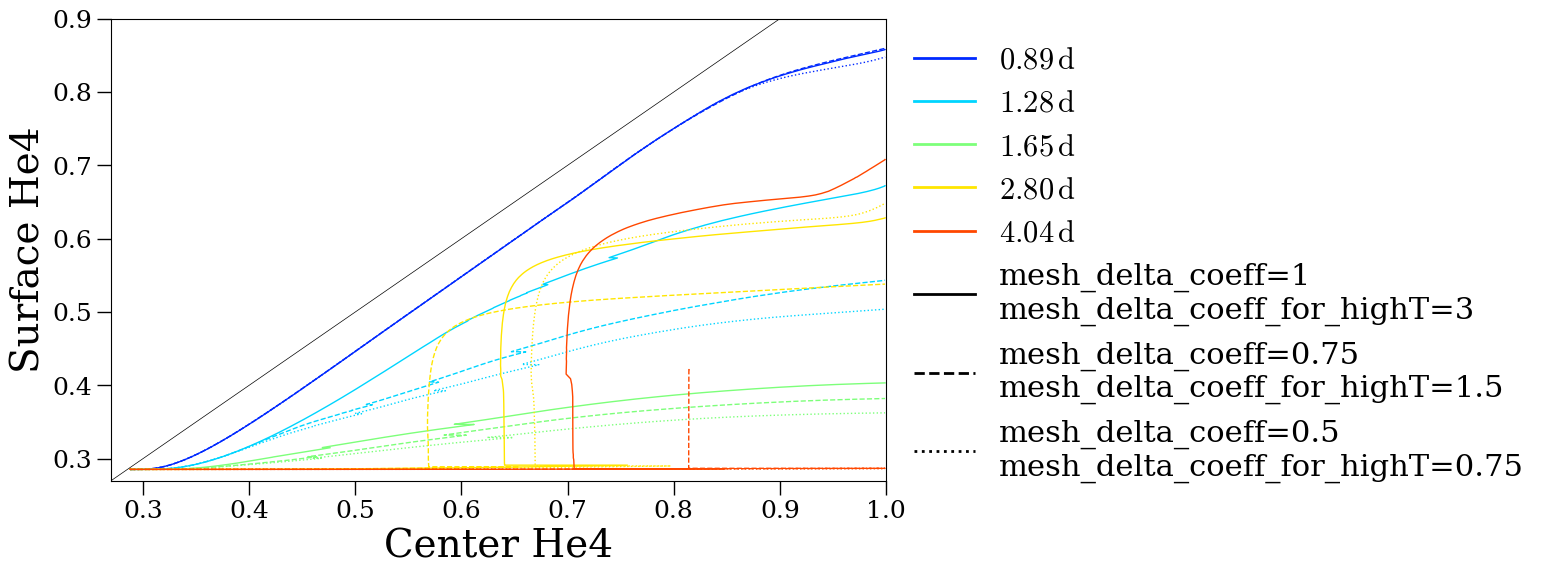

In [142]:
fig, ax = plt.subplots(figsize=(10, 6))
settings = dict(
    x='center_he4',
    y='surface_he4',
    invert_xaxis=False,
    invert_yaxis=False,
    model_dict_list=[model_dict1, model_dict2, model_dict3],
    model_styles=['-', '--', ':'],
    model_labels=[
        'mesh_delta_coeff=1\nmesh_delta_coeff_for_highT=3',
        'mesh_delta_coeff=0.75\nmesh_delta_coeff_for_highT=1.5',
        'mesh_delta_coeff=0.5\nmesh_delta_coeff_for_highT=0.75'
    ]
)

ax = history_plot(ax, **settings)
xlim = (0.27, 1)
ylim = (0.27, 0.9)
ax.plot(np.linspace(xlim[0], xlim[1], 10), np.linspace(xlim[0], xlim[1], 10), 'k-', lw=0.5)
ax.set_xlim(xlim)
ax.set_ylim(ylim)


ax.set_xlabel('Center He4')
ax.set_ylabel('Surface He4')

savefig(fig, 'hist_he4_ev')


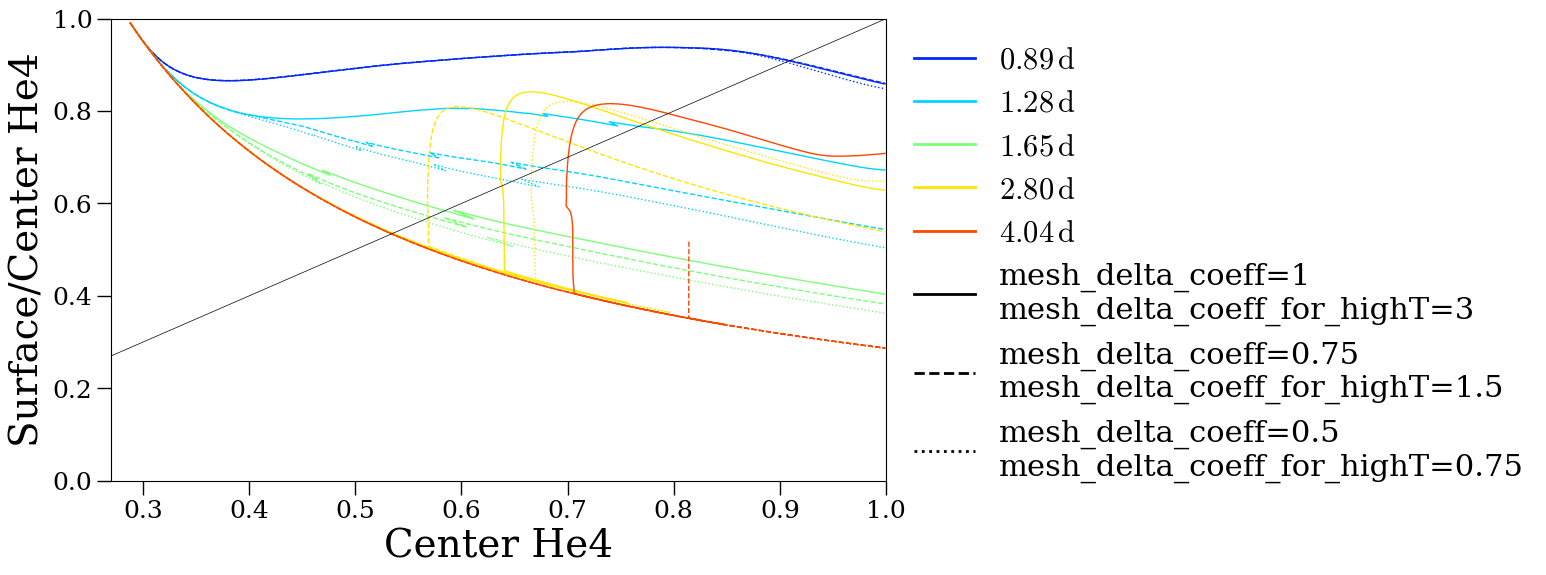

In [141]:
fig, ax = plt.subplots(figsize=(10, 6))
settings = dict(
    x='center_he4',
    y='surface_he4/center_he4',
    invert_xaxis=False,
    invert_yaxis=False,
    model_dict_list=[model_dict1, model_dict2, model_dict3],
    model_styles=['-', '--', ':'],
    model_labels=[
        'mesh_delta_coeff=1\nmesh_delta_coeff_for_highT=3',
        'mesh_delta_coeff=0.75\nmesh_delta_coeff_for_highT=1.5',
        'mesh_delta_coeff=0.5\nmesh_delta_coeff_for_highT=0.75'
    ]
)

ax = history_plot(ax, **settings)
xlim = (0.27, 1)
ylim = (0, 1)
ax.plot(np.linspace(xlim[0], xlim[1], 10), np.linspace(xlim[0], xlim[1], 10), 'k-', lw=0.5)
ax.set_xlim(xlim)
ax.set_ylim(ylim)


ax.set_xlabel('Center He4')
ax.set_ylabel('Surface/Center He4')

savefig(fig, 'hist_he4surf_div_he4center_ev')


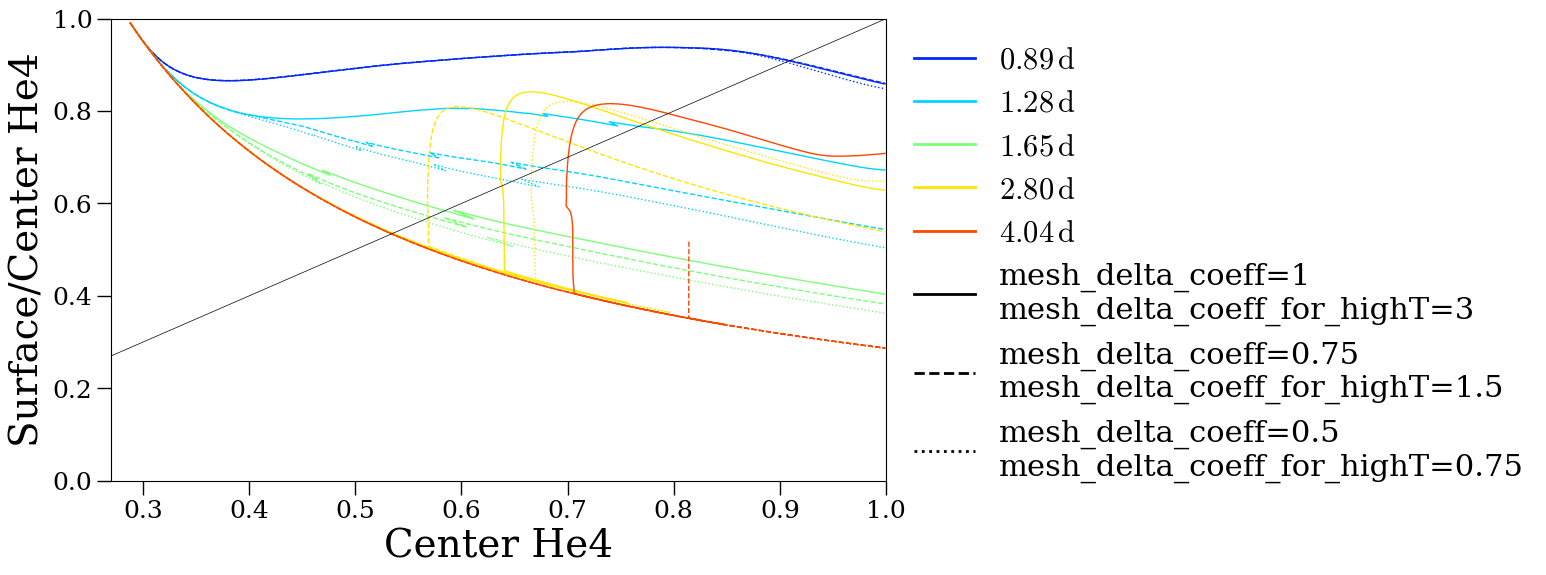

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
settings = dict(
    x='center_he4',
    y='surface_he4/center_he4',
    invert_xaxis=False,
    invert_yaxis=False,
    model_dict_list=[model_dict1, model_dict2, model_dict3],
    model_styles=['-', '--', ':'],
    model_labels=[
        'mesh_delta_coeff=1\nmesh_delta_coeff_for_highT=3',
        'mesh_delta_coeff=0.75\nmesh_delta_coeff_for_highT=1.5',
        'mesh_delta_coeff=0.5\nmesh_delta_coeff_for_highT=0.75'
    ]
)

ax = history_plot(ax, **settings)
xlim = (0.27, 1)
ylim = (0, 1)
ax.plot(np.linspace(xlim[0], xlim[1], 10), np.linspace(xlim[0], xlim[1], 10), 'k-', lw=0.5)
ax.set_xlim(xlim)
ax.set_ylim(ylim)


ax.set_xlabel('Center He4')
ax.set_ylabel('Surface/Center He4')

savefig(fig, 'hist_he4surf_div_he4center_ev')


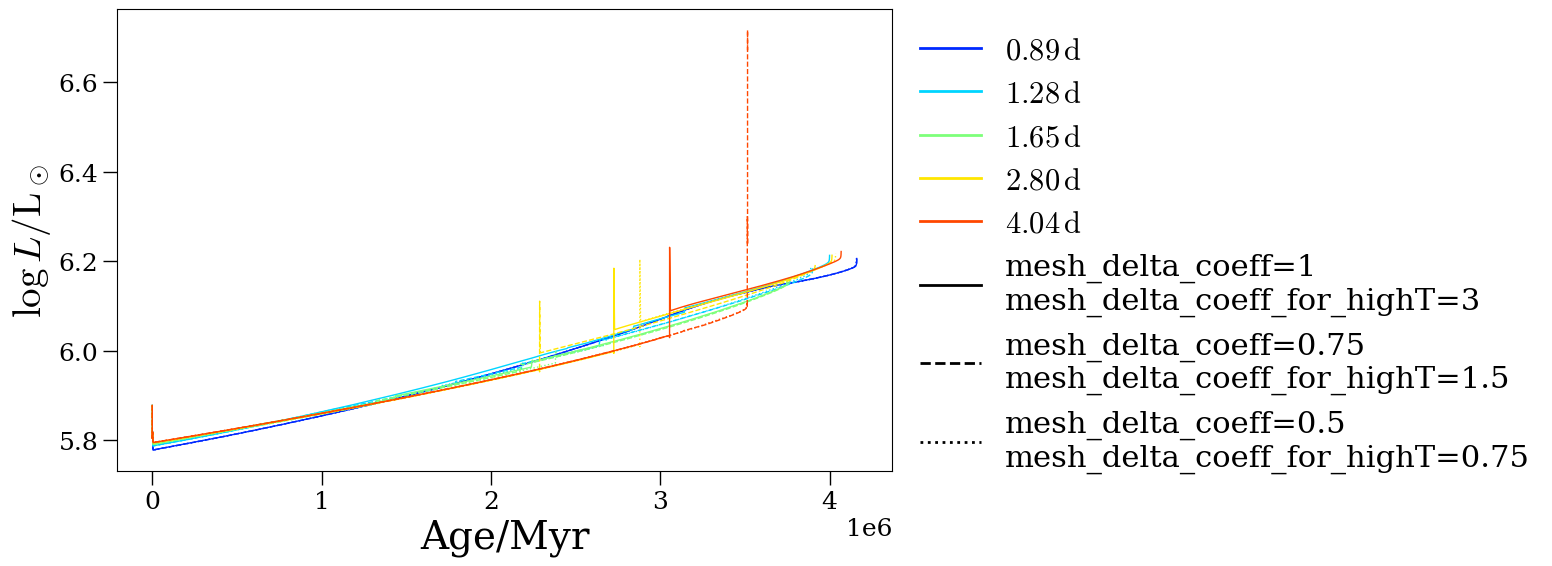

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
settings = dict(
    x='star_age',
    y='log_L',
    invert_xaxis=False,
    invert_yaxis=False,
    model_dict_list=[model_dict1, model_dict2, model_dict3],
    model_styles=['-', '--', ':'],
    model_labels=[
        'mesh_delta_coeff=1\nmesh_delta_coeff_for_highT=3',
        'mesh_delta_coeff=0.75\nmesh_delta_coeff_for_highT=1.5',
        'mesh_delta_coeff=0.5\nmesh_delta_coeff_for_highT=0.75'
    ]
)

ax = history_plot(ax, **settings)
#xlim = (0.27, 1)
#ylim = (0.27, 0.9)
#ax.plot(np.linspace(xlim[0], xlim[1], 10), np.linspace(xlim[0], xlim[1], 10), 'k-', lw=0.5)
#ax.set_xlim(xlim)
#ax.set_ylim(ylim)


ax.set_xlabel('Age/Myr')
ax.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')

savefig(fig, 'hist_logL_ev')


### Number of cells

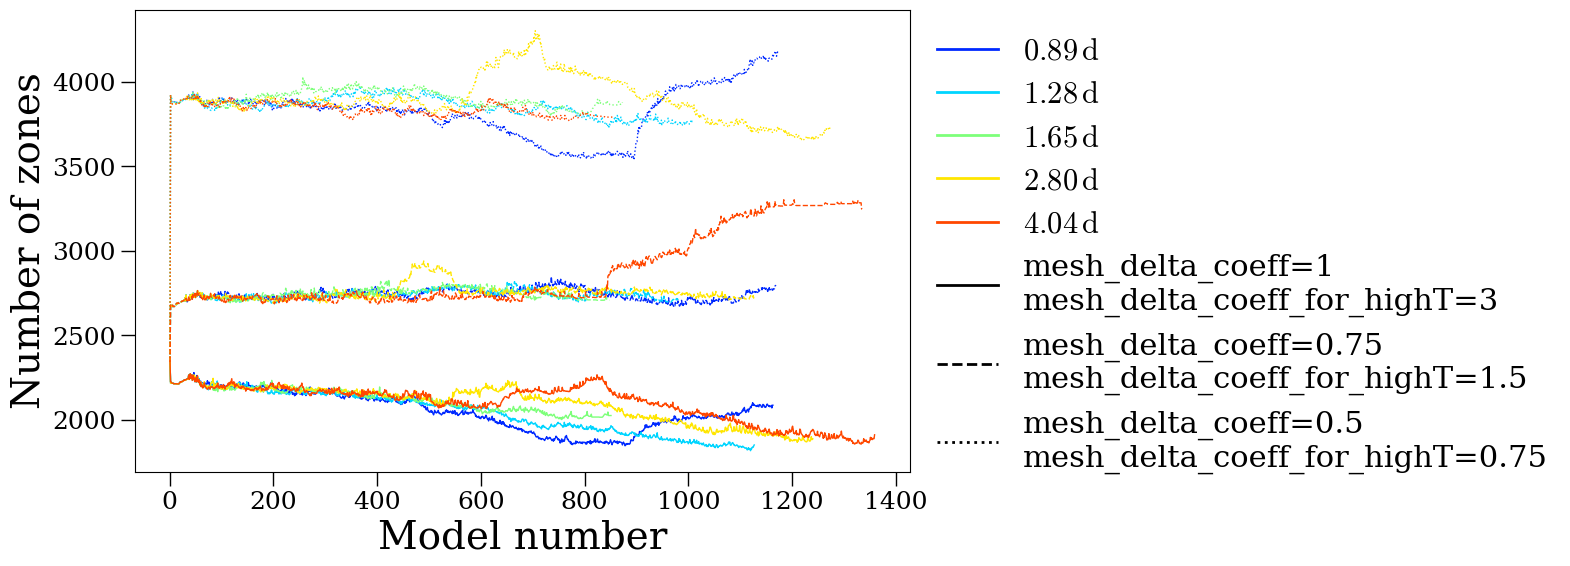

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
settings = dict(
    x='model_number',
    y='num_zones',
    invert_xaxis=False,
    invert_yaxis=False,
    model_dict_list=[model_dict1, model_dict2, model_dict3,],
    model_styles=['-', '--', ':'],
    model_labels=[
        'mesh_delta_coeff=1\nmesh_delta_coeff_for_highT=3',
        'mesh_delta_coeff=0.75\nmesh_delta_coeff_for_highT=1.5',
        'mesh_delta_coeff=0.5\nmesh_delta_coeff_for_highT=0.75'
    ]
)

ax = history_plot(ax, **settings)
#xlim = (0.27, 1)
#ylim = (0.27, 0.9)
#ax.plot(np.linspace(xlim[0], xlim[1], 10), np.linspace(xlim[0], xlim[1], 10), 'k-', lw=0.5)
#ax.set_xlim(xlim)
#ax.set_ylim(ylim)


ax.set_xlabel('Model number')
ax.set_ylabel('Number of zones')


savefig(fig, 'hist_no_cells_ev')


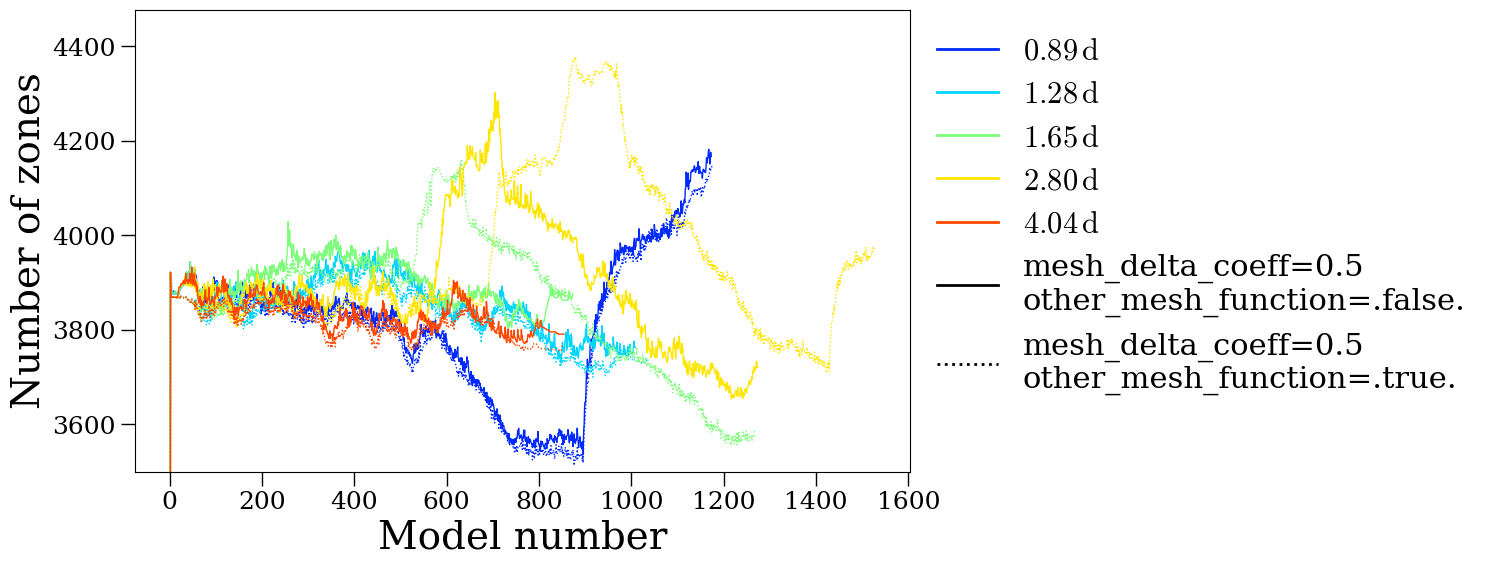

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
settings = dict(
    x='model_number',
    y='num_zones',
    invert_xaxis=False,
    invert_yaxis=False,
    model_dict_list=[model_dict3, model_dict32],
    model_styles=['-', ':'],
    model_labels=[
        'mesh_delta_coeff=0.5\nother_mesh_function=.false.',
        'mesh_delta_coeff=0.5\nother_mesh_function=.true.'
    ]
)

ax = history_plot(ax, **settings)

ax.set_xlabel('Model number')
ax.set_ylabel('Number of zones')

ax.set_ylim(3500)

savefig(fig, 'hist_no_cells_ev_mesh_onoff')

### Rotation and radius

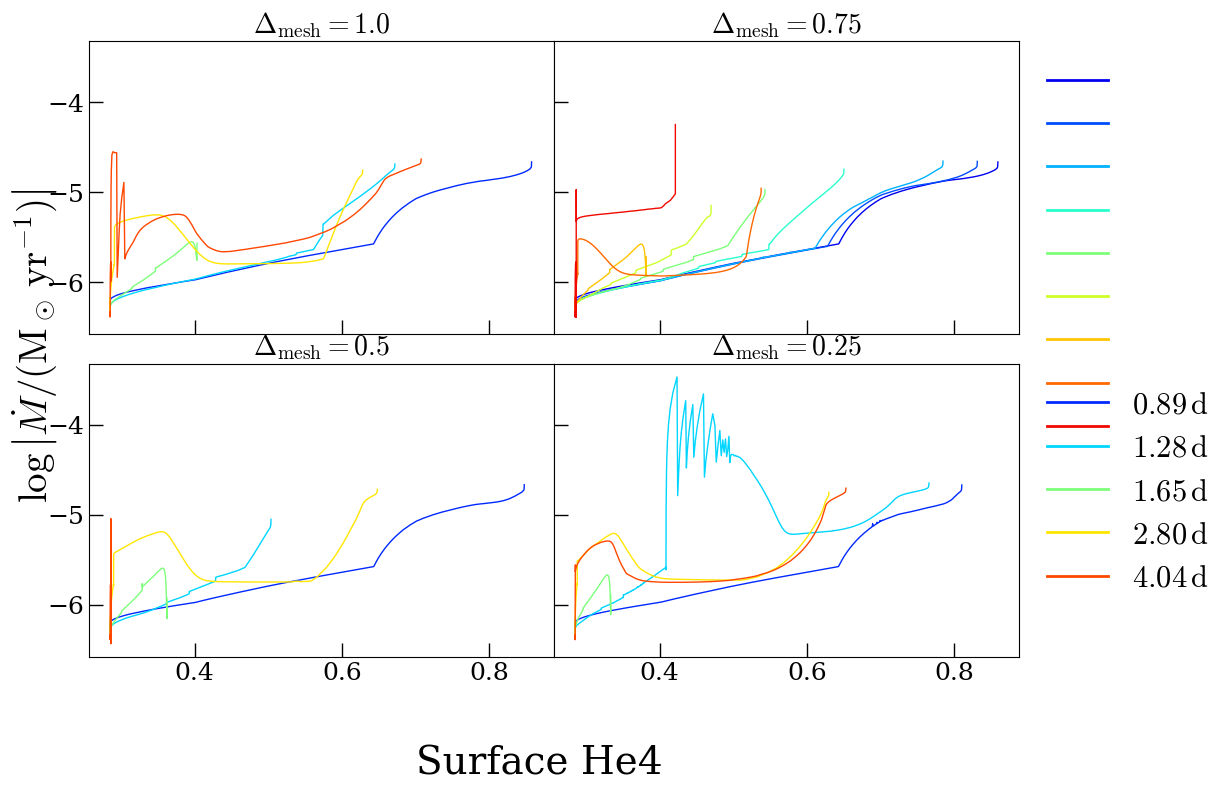

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()
fig.subplots_adjust(wspace=0, hspace=0.1)

model_dict_list = [model_dict1, model_dict2, model_dict3, model_dict4]
model_labels = [
    '$\\Delta_\\mathrm{mesh}=1.0$',
    '$\\Delta_\\mathrm{mesh}=0.75$',
    '$\\Delta_\\mathrm{mesh}=0.5$',
    '$\\Delta_\\mathrm{mesh}=0.25$'
]
model_styles = len(model_dict_list) * ['-']

for i, (ax, model_dict, model_label, model_style) in enumerate(zip(axes, model_dict_list, model_labels, model_styles)):
    if i == len(model_dict_list)-1:
        label_period = True
    else:
        label_period = False
    settings = dict(
        x='surface_he4',
        y='log_abs_mdot',
        invert_xaxis=True,
        invert_yaxis=False,
        model_dict_list=[model_dict],
        model_styles=[model_style],
        model_labels=[model_label],
        title=True,
        label_period=label_period
    )
    history_plot(ax, **settings)
    
for ax in axes:
    ax.tick_params(direction='in')
    #ax.set_ylim(5.75, 6.25)
    #ax.set_xlim(5, 4)

fig.text(0.5, 0, 'Surface He4', va='top', ha='center', transform=fig.transFigure)
fig.text(0.1, 0.5, '$\\log\\left|\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$', rotation=90, va='center', ha='right', transform=fig.transFigure)

savefig(fig, 'mdot_surfacehe4_res_panels')   

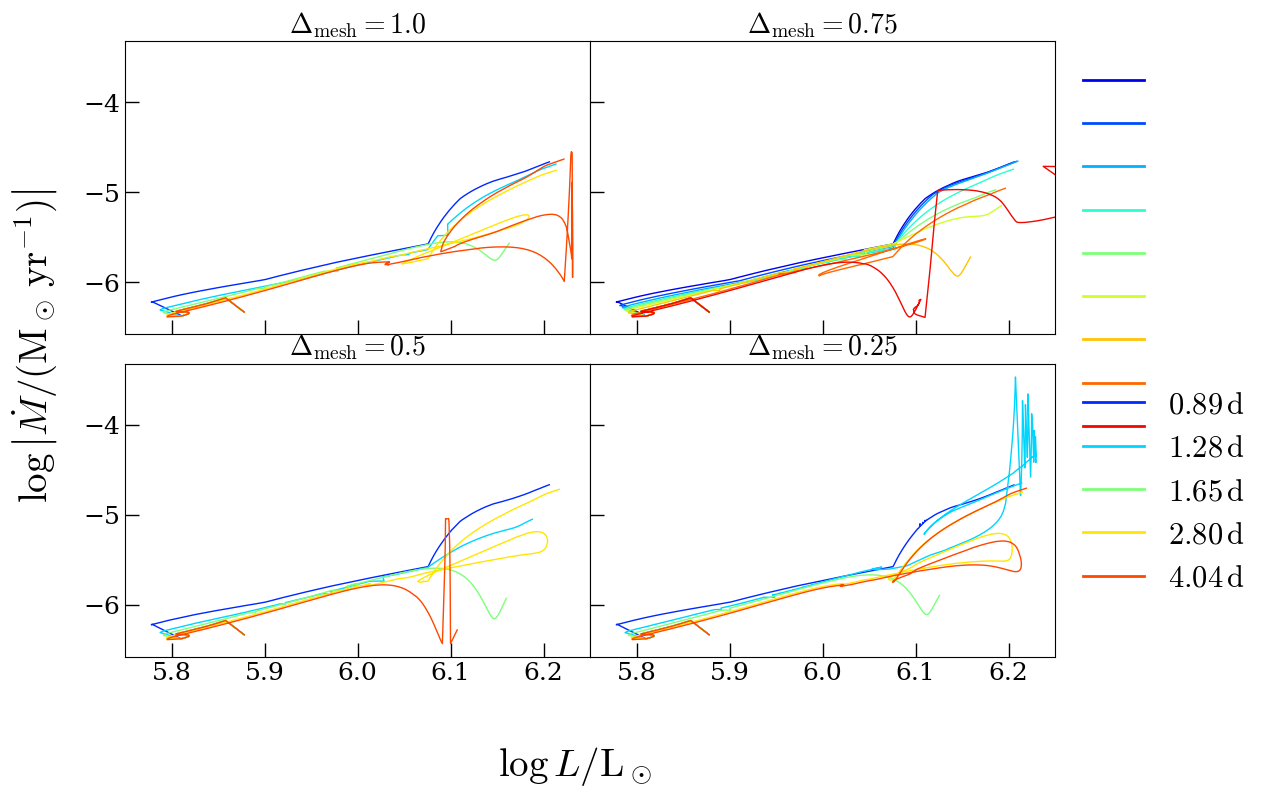

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()
fig.subplots_adjust(wspace=0, hspace=0.1)

model_dict_list = [model_dict1, model_dict2, model_dict3, model_dict4]
model_labels = [
    '$\\Delta_\\mathrm{mesh}=1.0$',
    '$\\Delta_\\mathrm{mesh}=0.75$',
    '$\\Delta_\\mathrm{mesh}=0.5$',
    '$\\Delta_\\mathrm{mesh}=0.25$'
]
model_styles = len(model_dict_list) * ['-']

for i, (ax, model_dict, model_label, model_style) in enumerate(zip(axes, model_dict_list, model_labels, model_styles)):
    if i == len(model_dict_list)-1:
        label_period = True
    else:
        label_period = False
    settings = dict(
        x='log_L',
        y='log_abs_mdot',
        invert_xaxis=True,
        invert_yaxis=False,
        model_dict_list=[model_dict],
        model_styles=[model_style],
        model_labels=[model_label],
        title=True,
        label_period=label_period
    )
    history_plot(ax, **settings)
    
for ax in axes:
    ax.tick_params(direction='in')
    #ax.set_ylim(5.75, 6.25)
    ax.set_xlim(5.75, 6.25)

fig.text(0.5, 0, '$\\log L/\\mathrm{L}_\\odot$', va='top', ha='center', transform=fig.transFigure)
fig.text(0.07, 0.5, '$\\log\\left|\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$', rotation=90, va='center', ha='right', transform=fig.transFigure)

savefig(fig, 'mdot_logL_res_panels')   

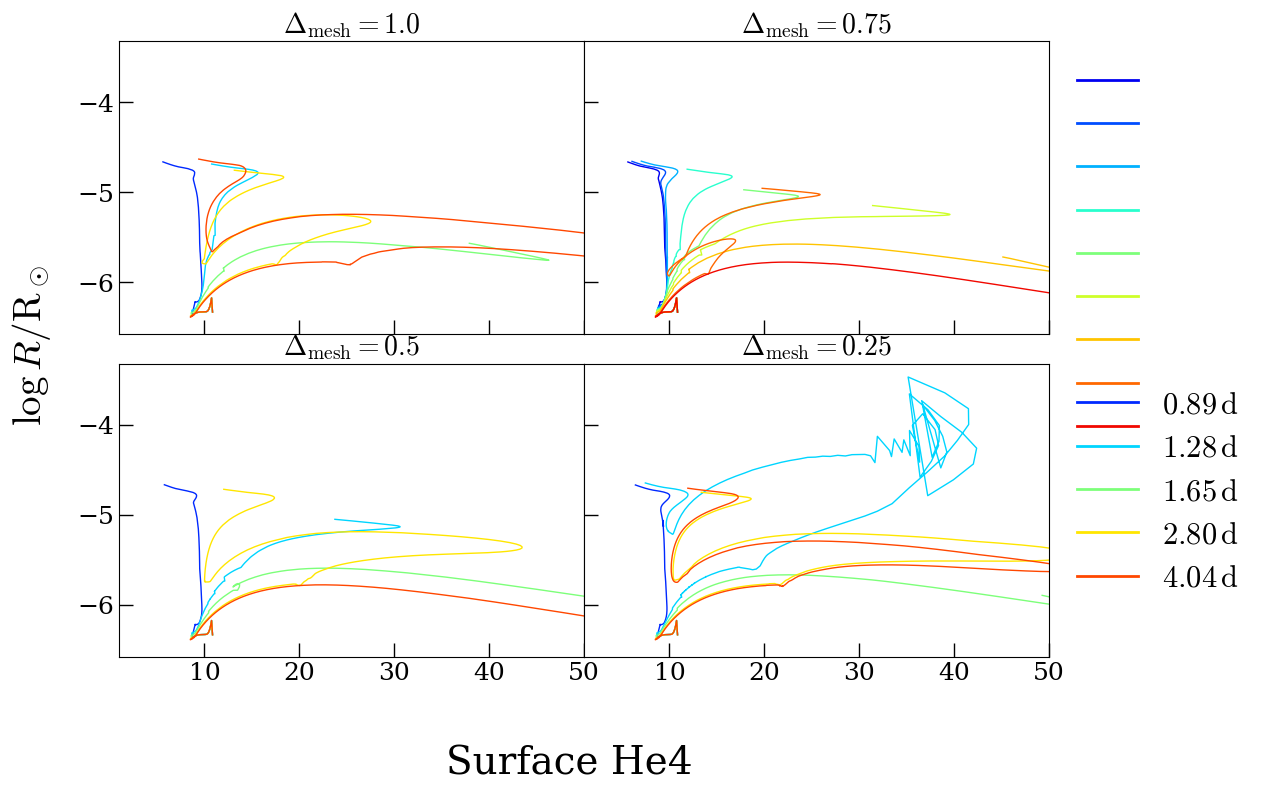

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()
fig.subplots_adjust(wspace=0, hspace=0.1)

model_dict_list = [model_dict1, model_dict2, model_dict3, model_dict4]
model_labels = [
    '$\\Delta_\\mathrm{mesh}=1.0$',
    '$\\Delta_\\mathrm{mesh}=0.75$',
    '$\\Delta_\\mathrm{mesh}=0.5$',
    '$\\Delta_\\mathrm{mesh}=0.25$'
]
model_styles = len(model_dict_list) * ['-']

for i, (ax, model_dict, model_label, model_style) in enumerate(zip(axes, model_dict_list, model_labels, model_styles)):
    if i == len(model_dict_list)-1:
        label_period = True
    else:
        label_period = False
    settings = dict(
        x='radius',
        y='log_abs_mdot',
        invert_xaxis=True,
        invert_yaxis=False,
        model_dict_list=[model_dict],
        model_styles=[model_style],
        model_labels=[model_label],
        title=True,
        label_period=label_period
    )
    history_plot(ax, **settings)
    
for ax in axes:
    ax.tick_params(direction='in')
    #ax.set_ylim(5.75, 6.25)
    ax.set_xlim(1, 50)

fig.text(0.5, 0, 'Surface He4', va='top', ha='center', transform=fig.transFigure)
fig.text(0.07, 0.5, '$\\log R/\\mathrm{R}_\\odot$', rotation=90, va='center', ha='right', transform=fig.transFigure)

savefig(fig, 'radius_surfacehe4_res_panels')   

(-6.5, -4.0)

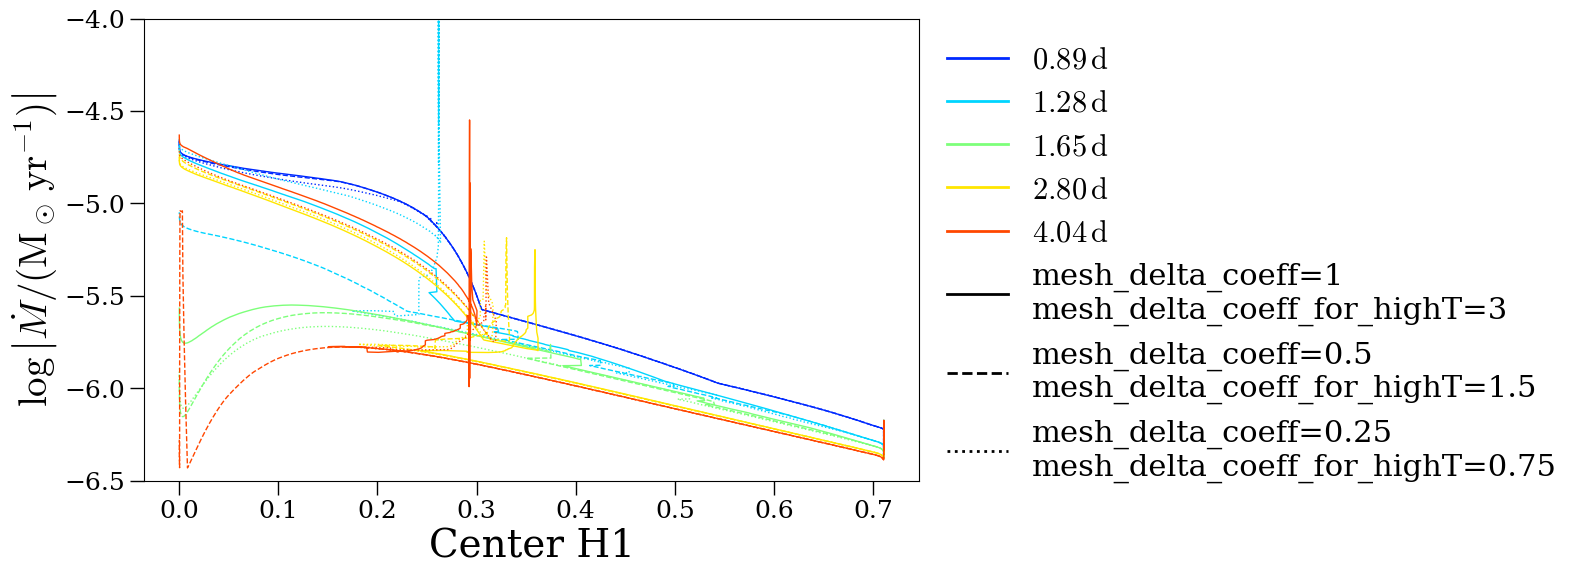

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
settings = dict(
    x='center_h1',
    y='log_abs_mdot',
    invert_xaxis=False,
    invert_yaxis=False,
    model_dict_list=[model_dict1, model_dict2, model_dict3],
    model_styles=['-', '--', ':'],
    model_labels=[
        'mesh_delta_coeff=1\nmesh_delta_coeff_for_highT=3',
        'mesh_delta_coeff=0.5\nmesh_delta_coeff_for_highT=1.5',
        'mesh_delta_coeff=0.25\nmesh_delta_coeff_for_highT=0.75'
    ]
)

ax = history_plot(ax, **settings)

ax.set_xlabel('Center H1')
ax.set_ylabel('$\\log\\left|\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax.set_ylim(-6.5, -4)

(-6.5, -4.0)

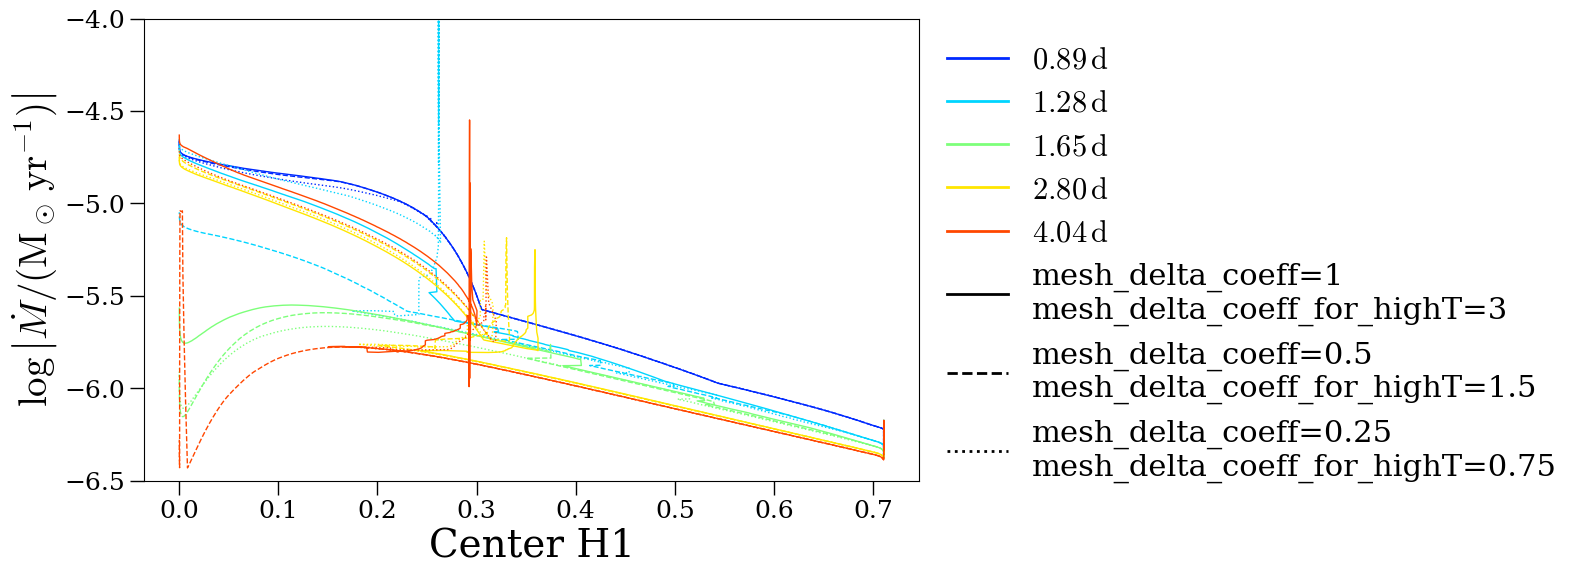

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
settings = dict(
    x='center_h1',
    y='log_abs_mdot',
    invert_xaxis=False,
    invert_yaxis=False,
    model_dict_list=[model_dict1, model_dict2, model_dict3],
    model_styles=['-', '--', ':'],
    model_labels=[
        'mesh_delta_coeff=1\nmesh_delta_coeff_for_highT=3',
        'mesh_delta_coeff=0.5\nmesh_delta_coeff_for_highT=1.5',
        'mesh_delta_coeff=0.25\nmesh_delta_coeff_for_highT=0.75'
    ]
)

ax = history_plot(ax, **settings)

ax.set_xlabel('Center H1')
ax.set_ylabel('$\\log\\left|\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')
ax.set_ylim(-6.5, -4)

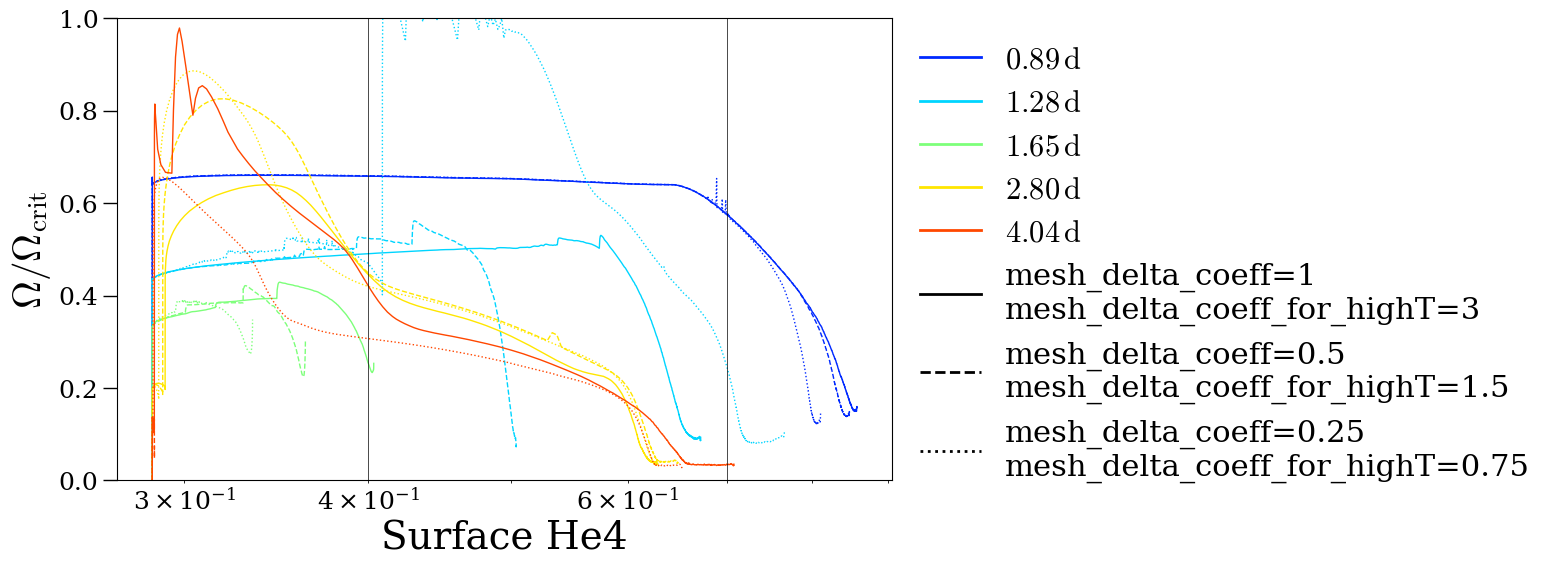

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
settings = dict(
    x='surface_he4',
    y='surf_avg_omega_div_omega_crit',
    invert_xaxis=False,
    invert_yaxis=False,
    model_dict_list=[model_dict1, model_dict2, model_dict3],
    model_styles=['-', '--', ':'],
    model_labels=[
        'mesh_delta_coeff=1\nmesh_delta_coeff_for_highT=3',
        'mesh_delta_coeff=0.5\nmesh_delta_coeff_for_highT=1.5',
        'mesh_delta_coeff=0.25\nmesh_delta_coeff_for_highT=0.75'
    ],
)

ax = history_plot(ax, **settings)

ax.set_xlabel('Surface He4')
ax.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')

ylim = (0, 1)
ax.vlines(0.4, *ylim, color='k', linewidth=0.5)
ax.vlines(0.7, *ylim, color='k', linewidth=0.5)
ax.set_ylim(ylim)
ax.set_xscale('log')

(0.0, 1.0)

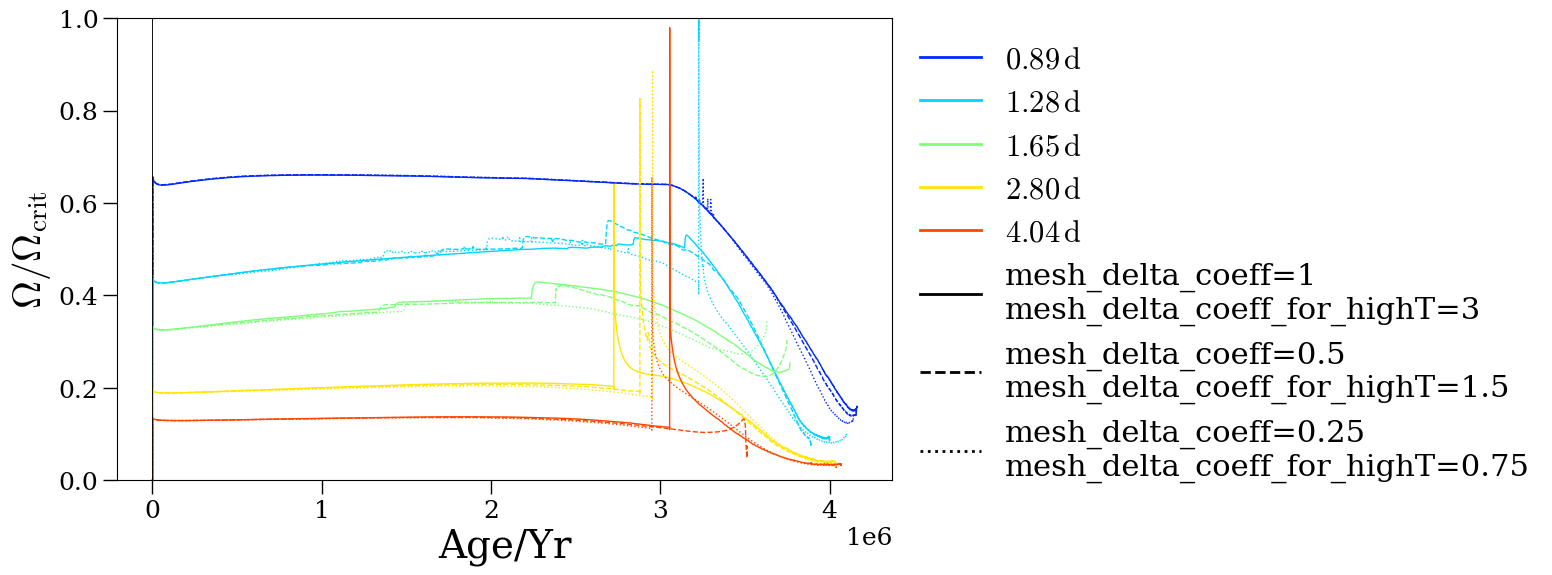

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
settings = dict(
    x='star_age',
    y='surf_avg_omega_div_omega_crit',
    invert_xaxis=False,
    invert_yaxis=False,
    model_dict_list=[model_dict1, model_dict2, model_dict3],
    model_styles=['-', '--', ':'],
    model_labels=[
        'mesh_delta_coeff=1\nmesh_delta_coeff_for_highT=3',
        'mesh_delta_coeff=0.5\nmesh_delta_coeff_for_highT=1.5',
        'mesh_delta_coeff=0.25\nmesh_delta_coeff_for_highT=0.75'
    ]
)

ax = history_plot(ax, **settings)

ax.set_xlabel('Age/Yr')
ax.set_ylabel('$\\Omega/\\Omega_\\mathrm{crit}$')

ylim = (0, 1)
ax.vlines(0.4, *ylim, color='k', linewidth=0.5)
ax.vlines(0.7, *ylim, color='k', linewidth=0.5)
ax.set_ylim(ylim)

Text(0, 0.5, '$R/\\mathrm{R}_\\odot$')

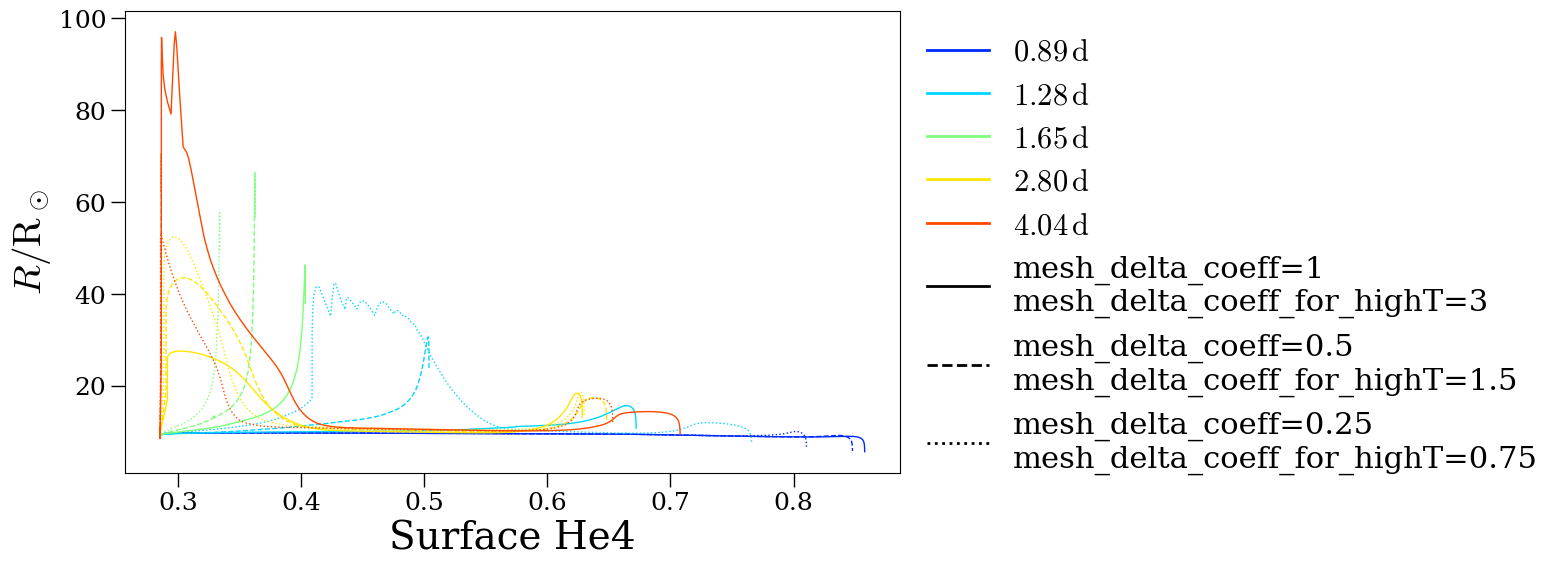

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
settings = dict(
    x='surface_he4',
    y='radius',
    invert_xaxis=False,
    invert_yaxis=False,
    model_dict_list=[model_dict1, model_dict2, model_dict3],
    model_styles=['-', '--', ':'],
    model_labels=[
        'mesh_delta_coeff=1\nmesh_delta_coeff_for_highT=3',
        'mesh_delta_coeff=0.5\nmesh_delta_coeff_for_highT=1.5',
        'mesh_delta_coeff=0.25\nmesh_delta_coeff_for_highT=0.75'
    ]
)

ax = history_plot(ax, **settings)

ax.set_xlabel('Surface He4')
ax.set_ylabel('$R/\\mathrm{R}_\\odot$')

Text(0, 0.5, '$R/\\mathrm{R}_\\odot$')

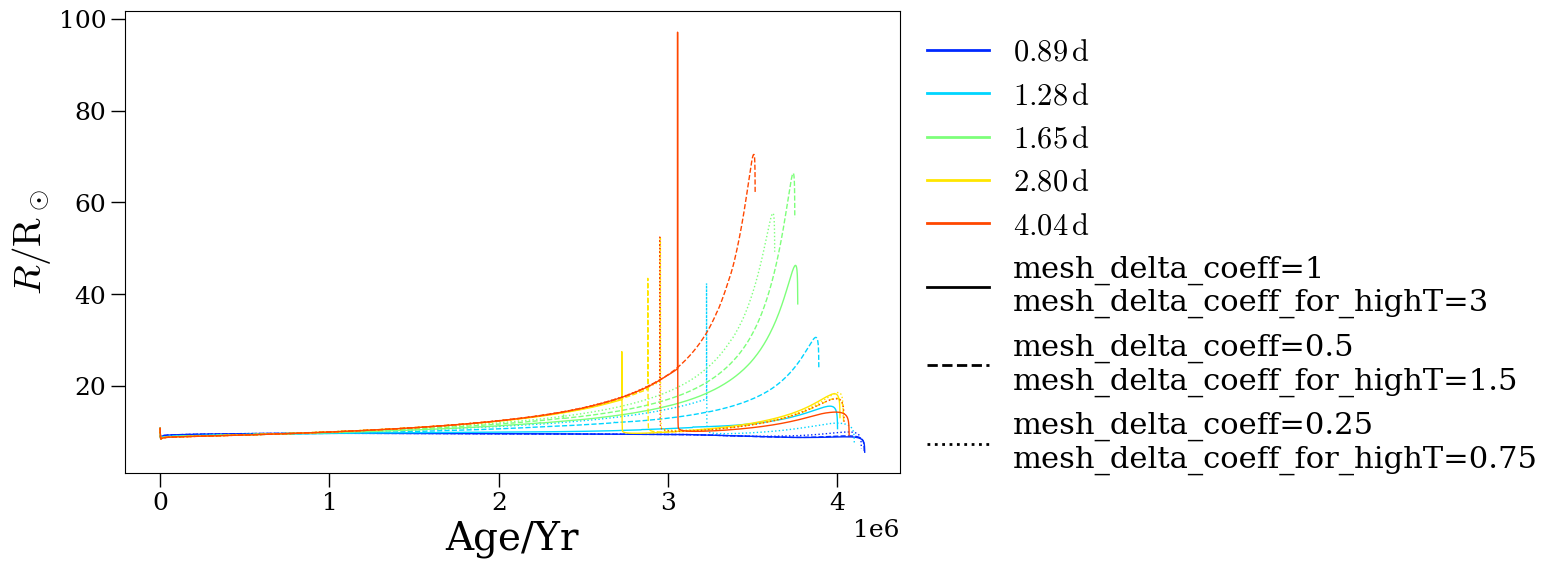

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
settings = dict(
    x='star_age',
    y='radius',
    invert_xaxis=False,
    invert_yaxis=False,
    model_dict_list=[model_dict1, model_dict2, model_dict3],
    model_styles=['-', '--', ':'],
    model_labels=[
        'mesh_delta_coeff=1\nmesh_delta_coeff_for_highT=3',
        'mesh_delta_coeff=0.5\nmesh_delta_coeff_for_highT=1.5',
        'mesh_delta_coeff=0.25\nmesh_delta_coeff_for_highT=0.75'
    ]
)

ax = history_plot(ax, **settings)

ax.set_xlabel('Age/Yr')
ax.set_ylabel('$R/\\mathrm{R}_\\odot$')

Text(0, 0.5, '$M/\\mathrm{M}_\\odot$')

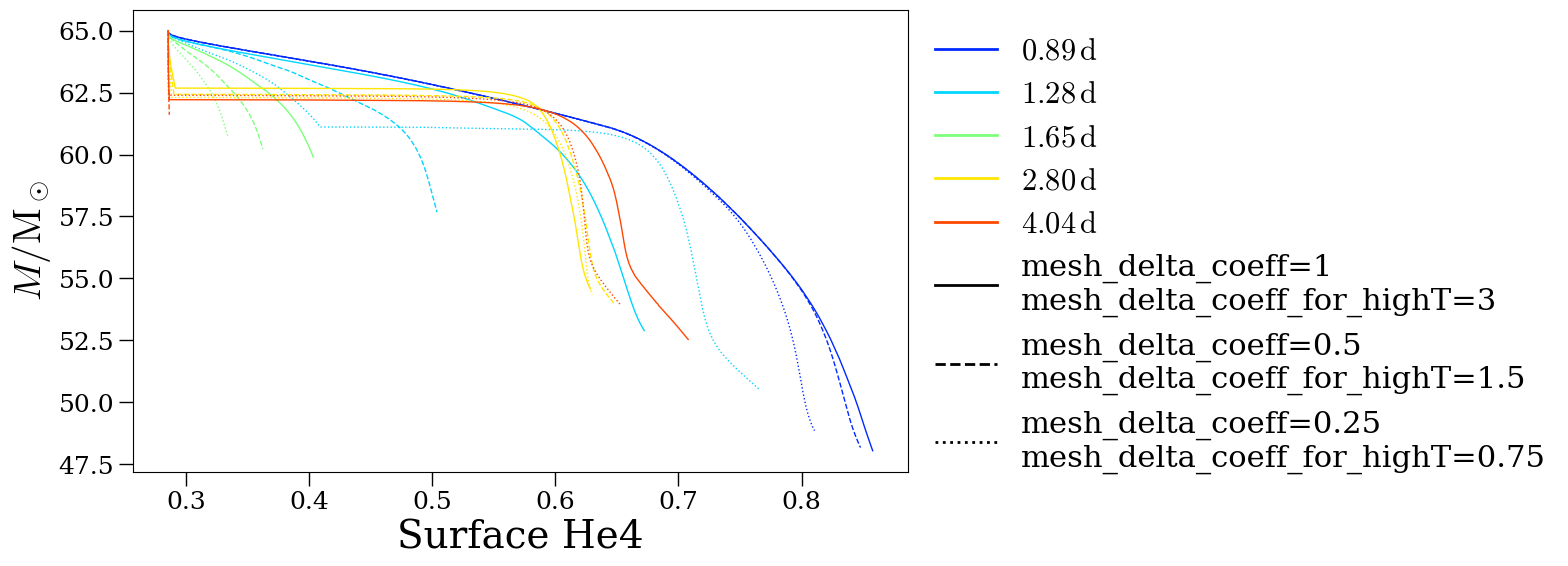

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
settings = dict(
    x='surface_he4',
    y='star_mass',
    invert_xaxis=False,
    invert_yaxis=False,
    model_dict_list=[model_dict1, model_dict2, model_dict3],
    model_styles=['-', '--', ':'],
    model_labels=[
        'mesh_delta_coeff=1\nmesh_delta_coeff_for_highT=3',
        'mesh_delta_coeff=0.5\nmesh_delta_coeff_for_highT=1.5',
        'mesh_delta_coeff=0.25\nmesh_delta_coeff_for_highT=0.75'
    ]
)

ax = history_plot(ax, **settings)

ax.set_xlabel('Surface He4')
ax.set_ylabel('$M/\\mathrm{M}_\\odot$')

Text(0, 0.5, '$R/\\mathrm{R}_\\odot$')

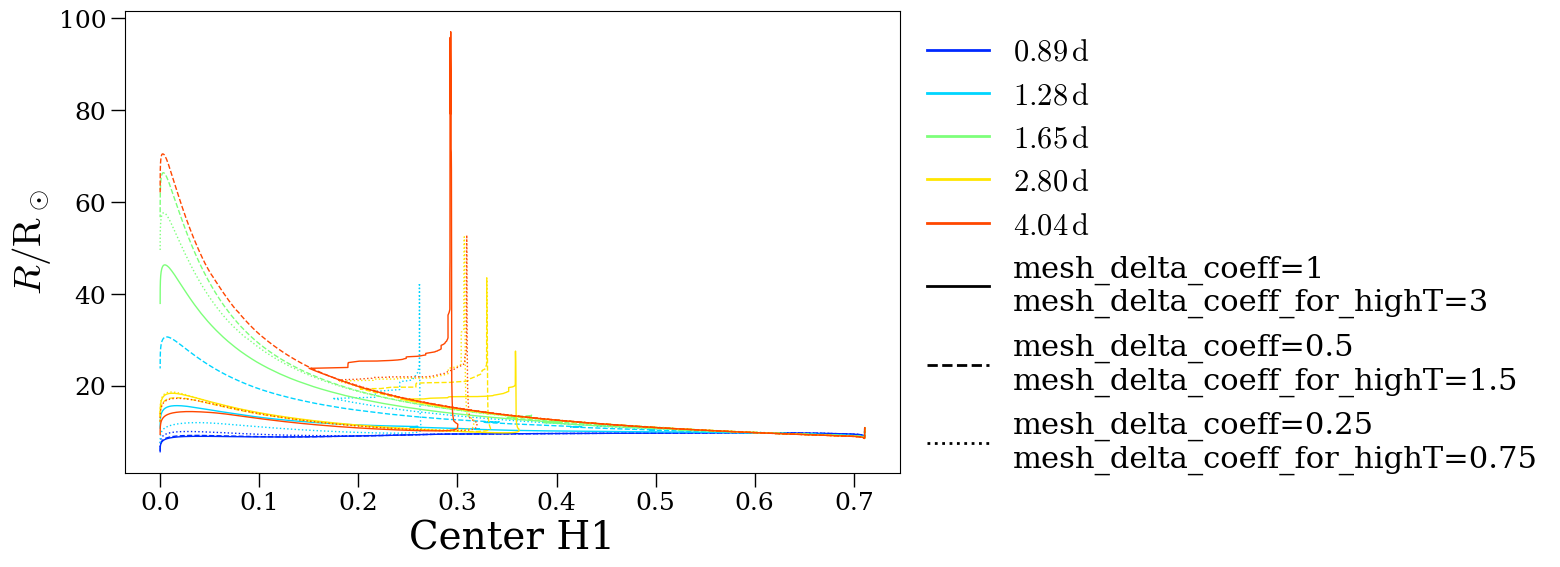

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
settings = dict(
    x='center_h1',
    y='radius',
    invert_xaxis=False,
    invert_yaxis=False,
    model_dict_list=[model_dict1, model_dict2, model_dict3],
    model_styles=['-', '--', ':'],
    model_labels=[
        'mesh_delta_coeff=1\nmesh_delta_coeff_for_highT=3',
        'mesh_delta_coeff=0.5\nmesh_delta_coeff_for_highT=1.5',
        'mesh_delta_coeff=0.25\nmesh_delta_coeff_for_highT=0.75'
    ]
)

ax = history_plot(ax, **settings)

ax.set_xlabel('Center H1')
ax.set_ylabel('$R/\\mathrm{R}_\\odot$')

Text(0.6, 2.2, 'pp chain')

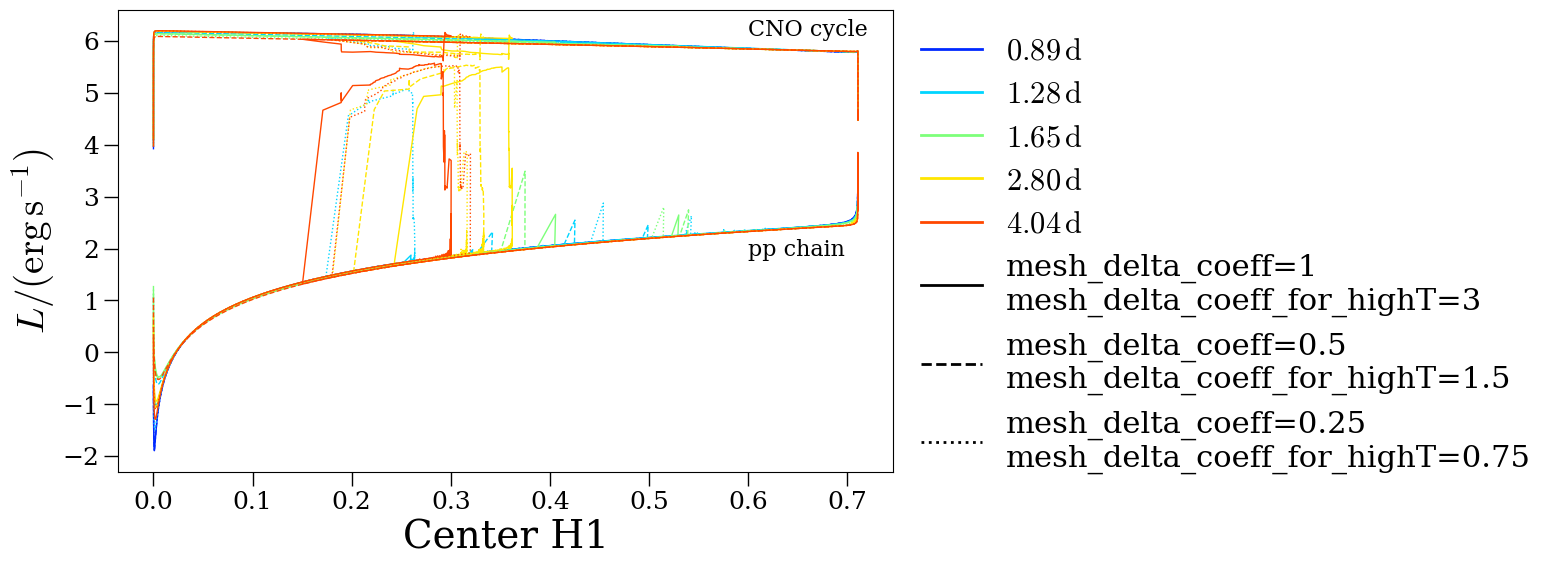

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

settings = dict(
    x='center_h1',
    y='pp',
    invert_xaxis=False,
    invert_yaxis=False,
    model_dict_list=[model_dict1, model_dict2, model_dict3],
    model_styles=['-', '--', ':'],
    model_labels=[
        'mesh_delta_coeff=1\nmesh_delta_coeff_for_highT=3',
        'mesh_delta_coeff=0.5\nmesh_delta_coeff_for_highT=1.5',
        'mesh_delta_coeff=0.25\nmesh_delta_coeff_for_highT=0.75'
    ]
)
ax = history_plot(ax, **settings)

settings = dict(
    x='center_h1',
    y='cno',
    invert_xaxis=False,
    invert_yaxis=False,
    model_dict_list=[model_dict1, model_dict2, model_dict3],
    model_styles=['-', '--', ':'],
    model_labels=[
        'mesh_delta_coeff=1\nmesh_delta_coeff_for_highT=3',
        'mesh_delta_coeff=0.5\nmesh_delta_coeff_for_highT=1.5',
        'mesh_delta_coeff=0.25\nmesh_delta_coeff_for_highT=0.75'
    ]
)
ax = history_plot(ax, **settings)

ax.set_xlabel('Center H1')
ax.set_ylabel('$L/(\\mathrm{erg}\\,\\mathrm{s}^{-1})$')
#ax.set_ylim(-6.5, -4)

ax.text(0.6, 6.0, 'CNO cycle', ha='left', va='bottom', transform=ax.transData, fontsize=16)
ax.text(0.6, 2.2, 'pp chain', ha='left', va='top', transform=ax.transData, fontsize=16)

Text(0, 0.5, '$\\log T_\\mathrm{center}/\\mathrm{K}$')

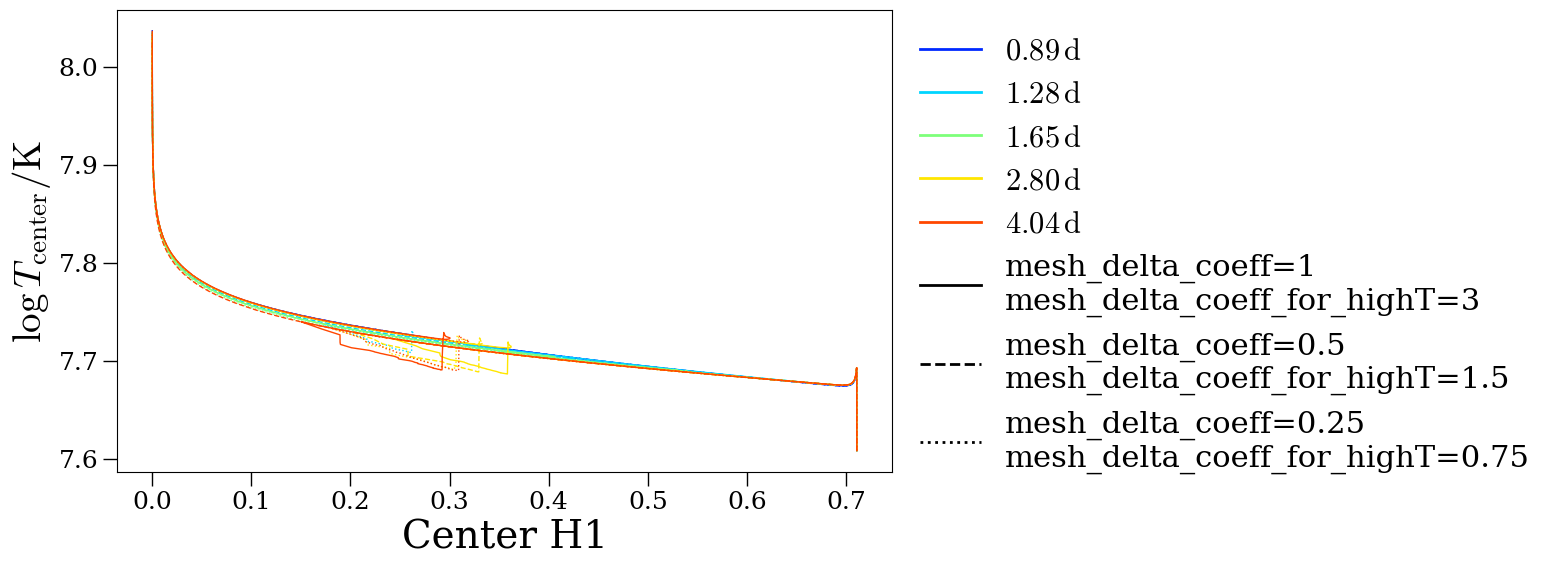

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

settings = dict(
    x='center_h1',
    y='log_center_T',
    invert_xaxis=False,
    invert_yaxis=False,
    model_dict_list=[model_dict1, model_dict2, model_dict3],
    model_styles=['-', '--', ':'],
    model_labels=[
        'mesh_delta_coeff=1\nmesh_delta_coeff_for_highT=3',
        'mesh_delta_coeff=0.5\nmesh_delta_coeff_for_highT=1.5',
        'mesh_delta_coeff=0.25\nmesh_delta_coeff_for_highT=0.75'
    ]
)
ax = history_plot(ax, **settings)

ax.set_xlabel('Center H1')
ax.set_ylabel('$\\log T_\\mathrm{center}/\\mathrm{K}$')
#ax.set_ylim(-6.5, -4)

## Scatter plots

In [ ]:
def normarr(arr):
    return (arr-min(arr))/(max(arr)-min(arr))

In [ ]:
test_case = model_dict1['65.0']['4.04']
h = mr.MesaData(str(test_case/'LOGS/history.data'))
logs  = mr.MesaLogDir(str(test_case/'LOGS'))
profile_numbers = logs.profile_numbers

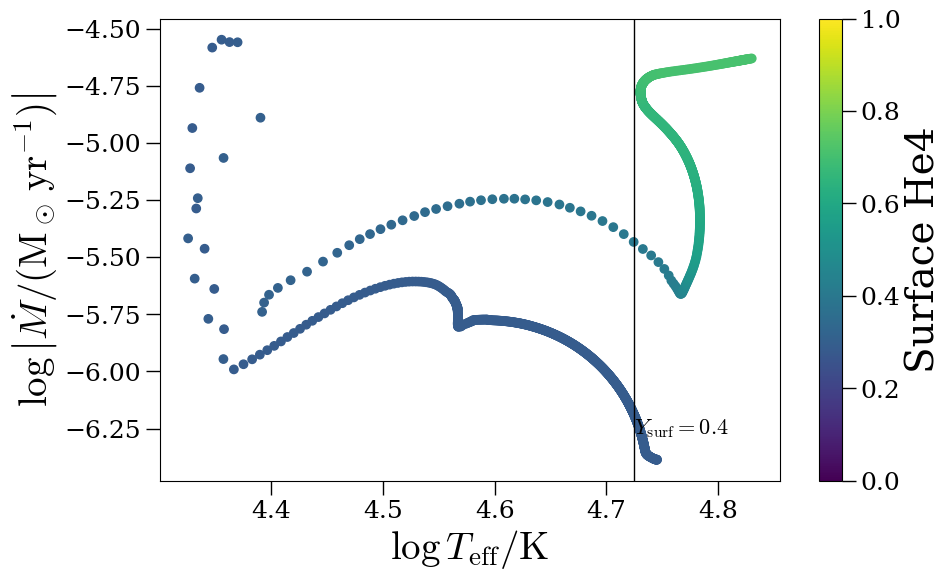

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

x = h.log_Teff
zams_i = np.where(h.surf_avg_omega_div_omega_crit>0)[0][0]
he04_i = np.where(h.surface_he4 >= 0.4)[0][0]
#he07_i = np.where(h.surface_he4 >= 0.7)[0][0]
c = cm.viridis(h.surface_he4[zams_i:])
#he07_i = np.where(h.surface_he4 >= 0.7)[0][0]

#ax.plot(x, normarr(h.star_mass), 'k-', lw=1, label='normalized $\\log M$')
#ax.plot(x, normarr(h.radius), 'r-', lw=1, label='normalized $\\log R$')
#ax.plot(x, h.surface_he4, 'g-', lw=1, label='Surf. He4')
#ax.plot(x, h.center_h1, 'g--', lw=1, label='Center. H1')
#ax.plot(x, h.surf_avg_omega_div_omega_crit, 'b-', lw=1, label='$\\Omega/\\Omega_\\mathrm{c}$')
ax.scatter(x[zams_i:], h.log_abs_mdot[zams_i:], c=c, label='normalized $\\log \\dot{M}$')

ylim = ax.get_ylim()
ax.vlines(x[he04_i], *ylim, color='k', ls='-', lw=1)
ax.text(x[he04_i], -6.25, '$Y_\\mathrm{surf}=0.4$', ha='left', va='center', transform=ax.transData,
        fontsize=16)
#ax.vlines(x[he07_i], *ylim, color='k', ls='-', lw=1)
#ax.text(x[he07_i], -6.25, '$Y_\\mathrm{surf}=0.7$', ha='left', va='center', transform=ax.transData,
        #fontsize=16)
ax.set_ylim(*ylim)

#ax.hlines(0.4, 0, 3.5, color='k', ls='--', lw=1)
#ax.hlines(0.7, 0, 3.5, color='k', ls='--', lw=1)

ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
ax.set_ylabel('$\\log\left|\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')

#ax.legend(ncol=3, loc='lower left', bbox_to_anchor=(0,1))
cb = fig.colorbar(ScalarMappable(Normalize(vmin=0, vmax=1), cmap=cm.viridis), ax=ax)
cb.set_label('Surface He4')


#ax.set_xlim(0, 1)
#ax.set_yscale('log')
#ax.invert_yaxis()

#ax.set_yscale('log')

In [ ]:
test_case = model_dict2['65.0']['4.04']
h = mr.MesaData(str(test_case/'LOGS/history.data'))
logs  = mr.MesaLogDir(str(test_case/'LOGS'))
profile_numbers = logs.profile_numbers

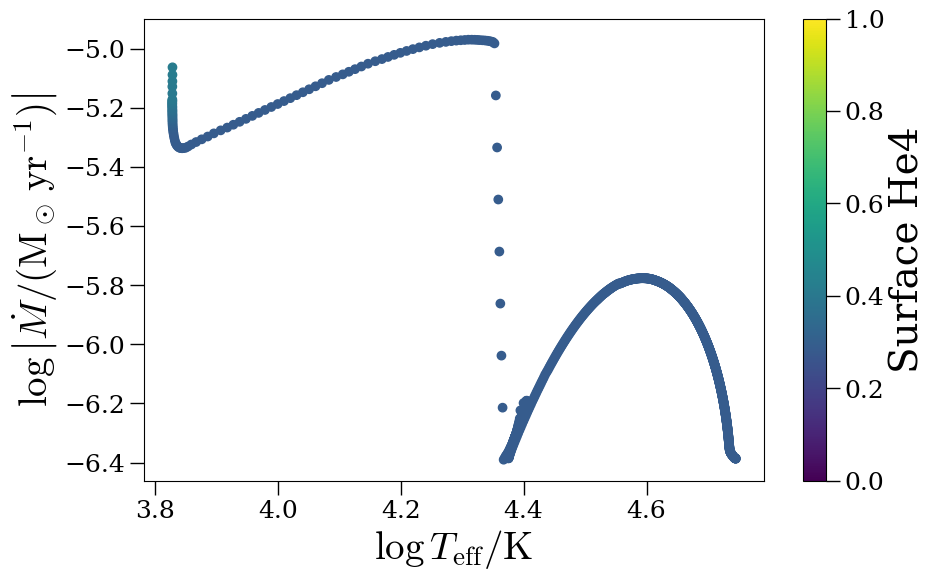

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

x = h.log_Teff
zams_i = np.where(h.surf_avg_omega_div_omega_crit>0)[0][0]
#he04_i = np.where(h.surface_he4 >= 0.4)[0][0]
#he07_i = np.where(h.surface_he4 >= 0.7)[0][0]
c = cm.viridis(h.surface_he4[zams_i:])
#he07_i = np.where(h.surface_he4 >= 0.7)[0][0]

#ax.plot(x, normarr(h.star_mass), 'k-', lw=1, label='normalized $\\log M$')
#ax.plot(x, normarr(h.radius), 'r-', lw=1, label='normalized $\\log R$')
#ax.plot(x, h.surface_he4, 'g-', lw=1, label='Surf. He4')
#ax.plot(x, h.center_h1, 'g--', lw=1, label='Center. H1')
#ax.plot(x, h.surf_avg_omega_div_omega_crit, 'b-', lw=1, label='$\\Omega/\\Omega_\\mathrm{c}$')
ax.scatter(x[zams_i:], h.log_abs_mdot[zams_i:], c=c, label='normalized $\\log \\dot{M}$')

ylim = ax.get_ylim()
#ax.vlines(x[he04_i], *ylim, color='k', ls='-', lw=1)
#ax.text(x[he04_i], -6.25, '$Y_\\mathrm{surf}=0.4$', ha='left', va='center', transform=ax.transData,
#        fontsize=16)
#ax.vlines(x[he07_i], *ylim, color='k', ls='-', lw=1)
#ax.text(x[he07_i], -6.25, '$Y_\\mathrm{surf}=0.7$', ha='left', va='center', transform=ax.transData,
        #fontsize=16)
ax.set_ylim(*ylim)

#ax.hlines(0.4, 0, 3.5, color='k', ls='--', lw=1)
#ax.hlines(0.7, 0, 3.5, color='k', ls='--', lw=1)

ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
ax.set_ylabel('$\\log\left|\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})\\right|$')

#ax.legend(ncol=3, loc='lower left', bbox_to_anchor=(0,1))
cb = fig.colorbar(ScalarMappable(Normalize(vmin=0, vmax=1), cmap=cm.viridis), ax=ax)
cb.set_label('Surface He4')


#ax.set_xlim(0, 1)
#ax.set_yscale('log')
#ax.invert_yaxis()

#ax.set_yscale('log')

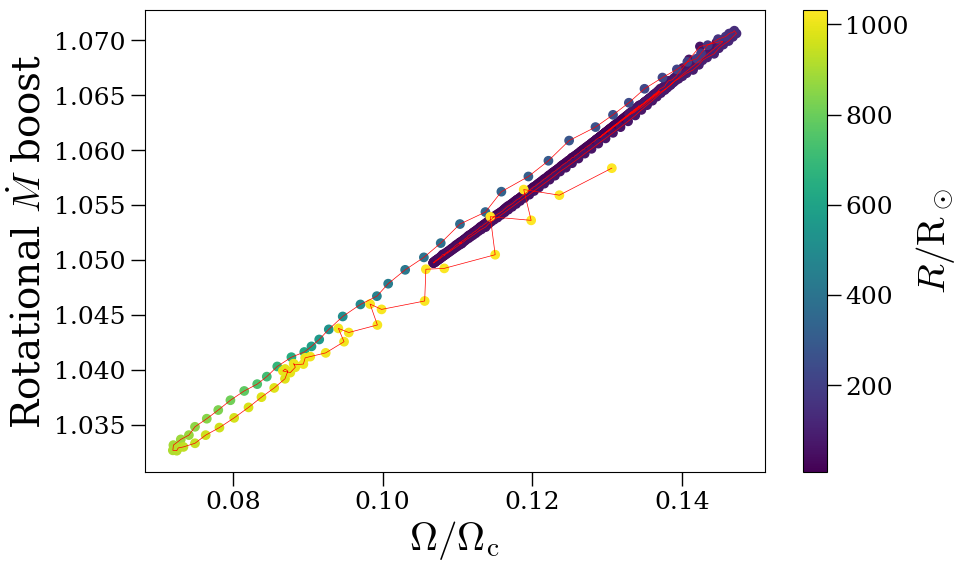

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

i_start = zams_i
i_end = -1
i_step = 1
cmap = cm.viridis

y = h.rotational_mdot_boost[i_start:i_end:i_step]
x = h.surf_avg_omega_div_omega_crit[i_start:i_end:i_step]
cdata = h.radius[i_start:i_end:i_step]
c = cmap(normarr(cdata))

ax.scatter(x, y, c=c, alpha=1)
ax.plot(x, y, c='r', lw=0.5, alpha=1)
ax.set_xlabel('$\\Omega/\\Omega_\\mathrm{c}$')
ax.set_ylabel('Rotational $\\dot{M}$ boost')

cb = fig.colorbar(ScalarMappable(Normalize(vmin=min(cdata), vmax=max(cdata)), cmap=cmap), ax=ax)
cb.set_label('$R/\\mathrm{R}_\\odot$')


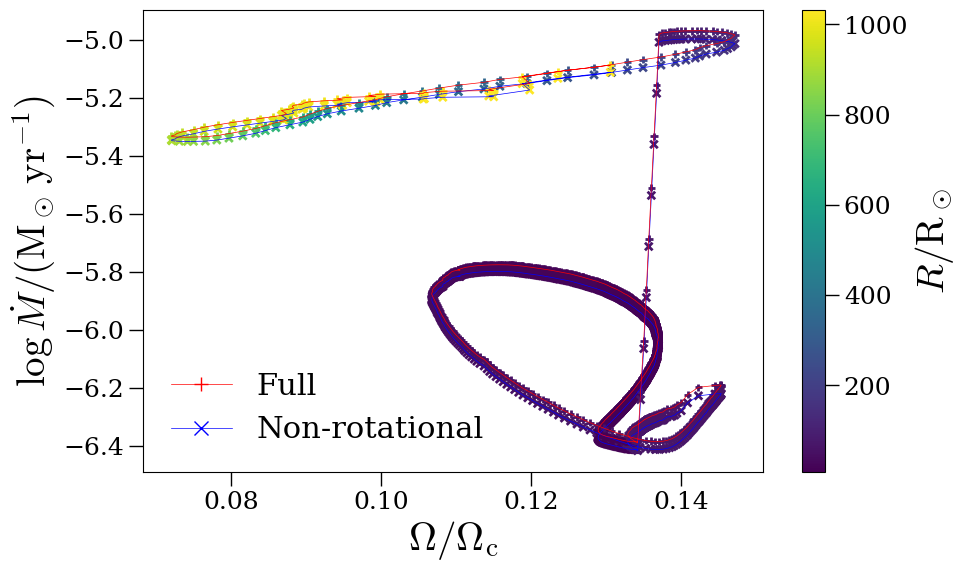

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

i_start = zams_i
i_end = -1
i_step = 1
cmap = cm.viridis

y1 = np.log10(10**h.log_abs_mdot[i_start:i_end:i_step]/h.rotational_mdot_boost[i_start:i_end:i_step])
y2 = np.log10(10**h.log_abs_mdot[i_start:i_end:i_step])#-10**h.log_abs_mdot[i_start:i_end:i_step]/h.rotational_mdot_boost[i_start:i_end:i_step])
x = h.surf_avg_omega_div_omega_crit[i_start:i_end:i_step]
cdata = h.radius[i_start:i_end:i_step]
c = cmap(normarr(cdata))

ax.scatter(x, y1, c=c, marker='x', alpha=1, s=30)
ax.plot(x, y1, c='b', lw=0.5, alpha=1)
ax.scatter(x, y2, c=c, marker='+', alpha=1, s=30)
ax.plot(x, y2, c='r', lw=0.5, alpha=1)
ax.set_xlabel('$\\Omega/\\Omega_\\mathrm{c}$')
ax.set_ylabel('$\\log\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})$')

cb = fig.colorbar(ScalarMappable(Normalize(vmin=min(cdata), vmax=max(cdata)), cmap=cmap), ax=ax)
cb.set_label('$R/\\mathrm{R}_\\odot$')

handles = []
handles.append(Line2D([], [], color='r', ls='-', lw=0.5, marker='+', ms=10, label='Full'))
handles.append(Line2D([], [], color='b', ls='-', lw=0.5, marker='x', ms=10, label='Non-rotational'))
ax.legend(handles=handles, frameon=False)


Error in callback <function _draw_all_if_interactive at 0x15551cff7370> (for post_execute):


KeyboardInterrupt: 

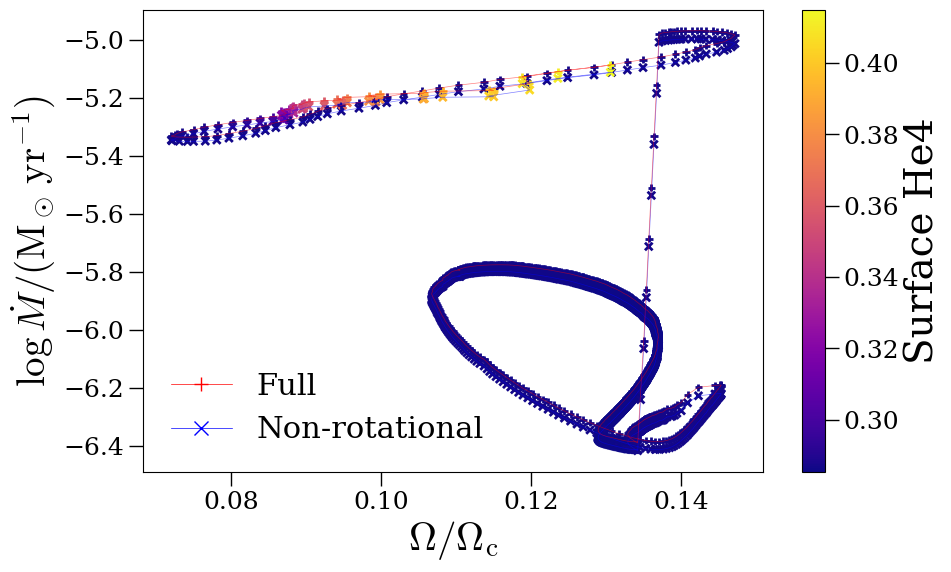

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

i_start = zams_i
i_end = -1
i_step = 1
cmap = cm.plasma

y1 = np.log10(10**h.log_abs_mdot[i_start:i_end:i_step]/h.rotational_mdot_boost[i_start:i_end:i_step])
y2 = np.log10(10**h.log_abs_mdot[i_start:i_end:i_step])#-10**h.log_abs_mdot[i_start:i_end:i_step]/h.rotational_mdot_boost[i_start:i_end:i_step])
x = h.surf_avg_omega_div_omega_crit[i_start:i_end:i_step]
cdata = h.surface_he4[i_start:i_end:i_step]
c = cmap(normarr(cdata))
he04_i = np.where(h.surface_he4 <= 0.4)[0][0]

ax.scatter(x, y1, c=c, marker='x', alpha=1, s=30)
ax.plot(x, y1, c='b', lw=0.5, alpha=0.5)
ax.scatter(x, y2, c=c, marker='+', alpha=1, s=30)
ax.plot(x, y2, c='r', lw=0.5, alpha=0.5)

ax.set_xlabel('$\\Omega/\\Omega_\\mathrm{c}$')
ax.set_ylabel('$\\log\\dot{M}/(\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1})$')

cb = fig.colorbar(ScalarMappable(Normalize(vmin=min(cdata), vmax=max(cdata)), cmap=cmap), ax=ax)
cb.set_label('Surface He4')

handles = []
handles.append(Line2D([], [], color='r', ls='-', lw=0.5, marker='+', ms=10, label='Full'))
handles.append(Line2D([], [], color='b', ls='-', lw=0.5, marker='x', ms=10, label='Non-rotational'))
ax.legend(handles=handles, frameon=False)


In [ ]:
mm = mp.MESA()
mm.loadHistory(f=str(model_dict2['65.0']['4.04']/'LOGS'))
mm.scrubHistory()

AttributeError: No attribute head_names

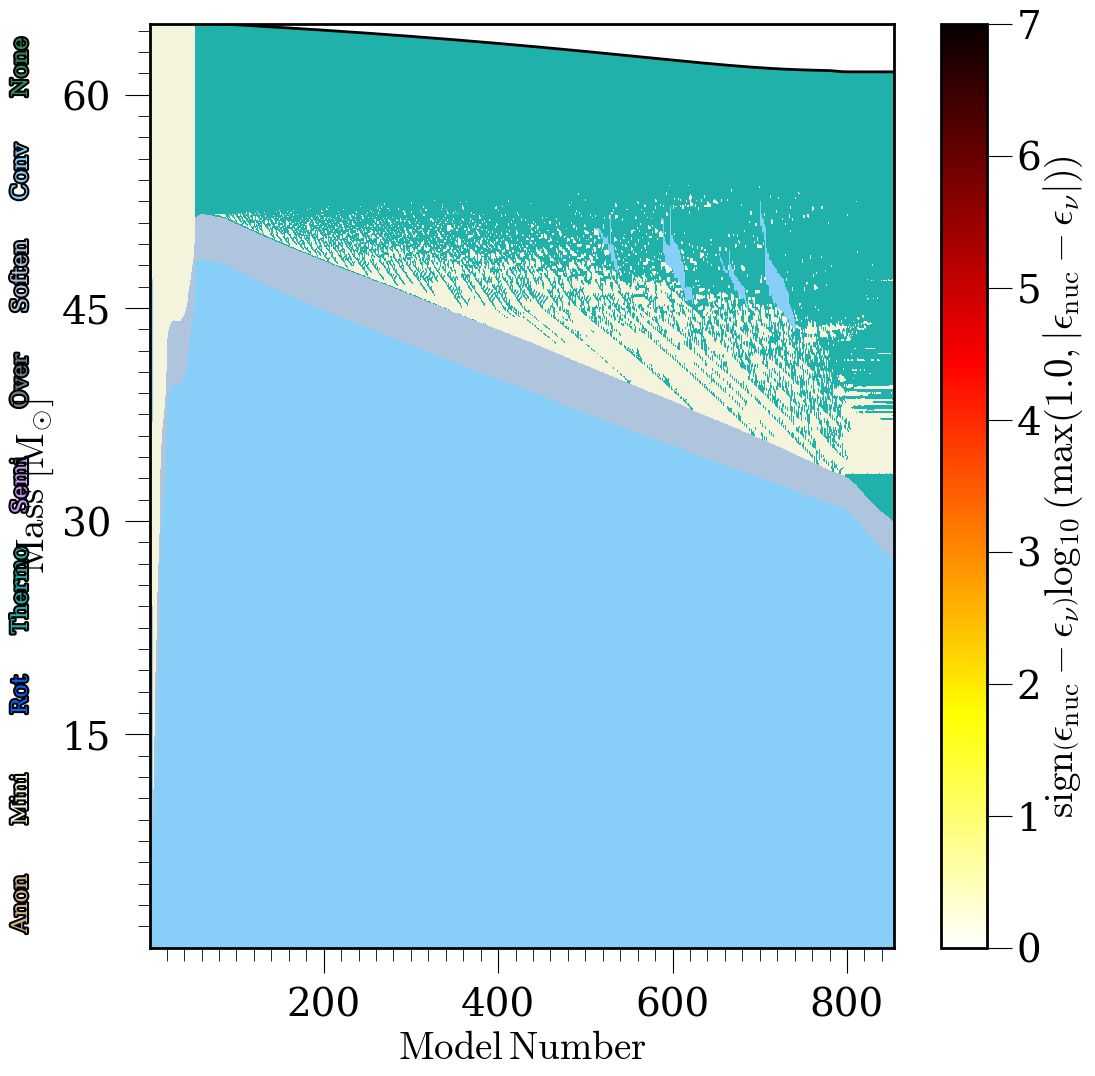

In [ ]:
p = mp.plot()
p.plotKip(mm)

In [ ]:
mm = mp.MESA()
mm.loadHistory(f=str(model_dict1['65.0']['4.04']/'LOGS'))
mm.scrubHistory()

AttributeError: No attribute head_names

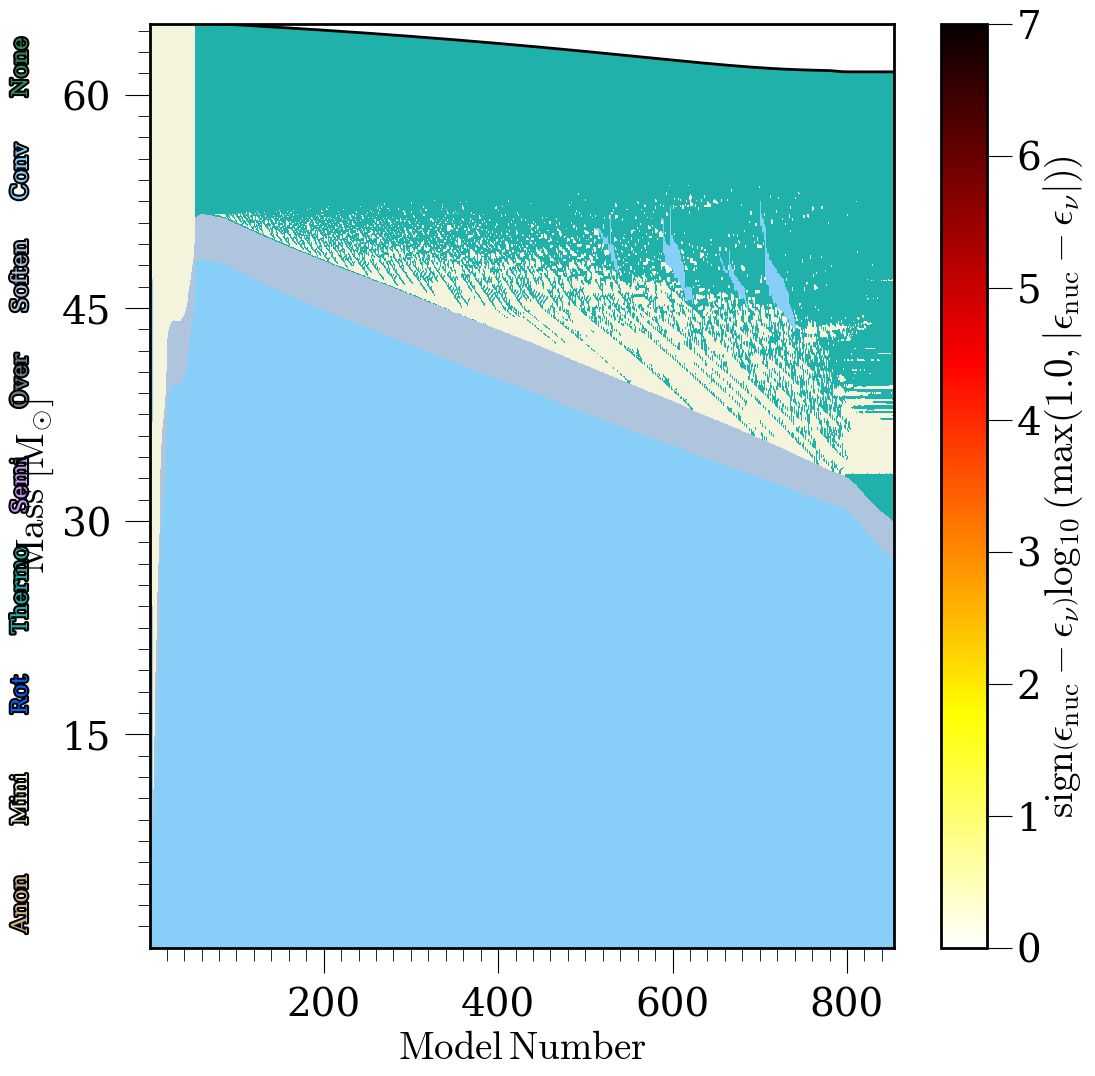

In [ ]:
p = mp.plot()
p.plotKip(mm)

#### Internal rotation

In [20]:
test_case = model_dict1['65.0']['1.28']
h = mr.MesaData(str(test_case/'LOGS/history.data'))
logs  = mr.MesaLogDir(str(test_case/'LOGS'))
profile_numbers = logs.profile_numbers

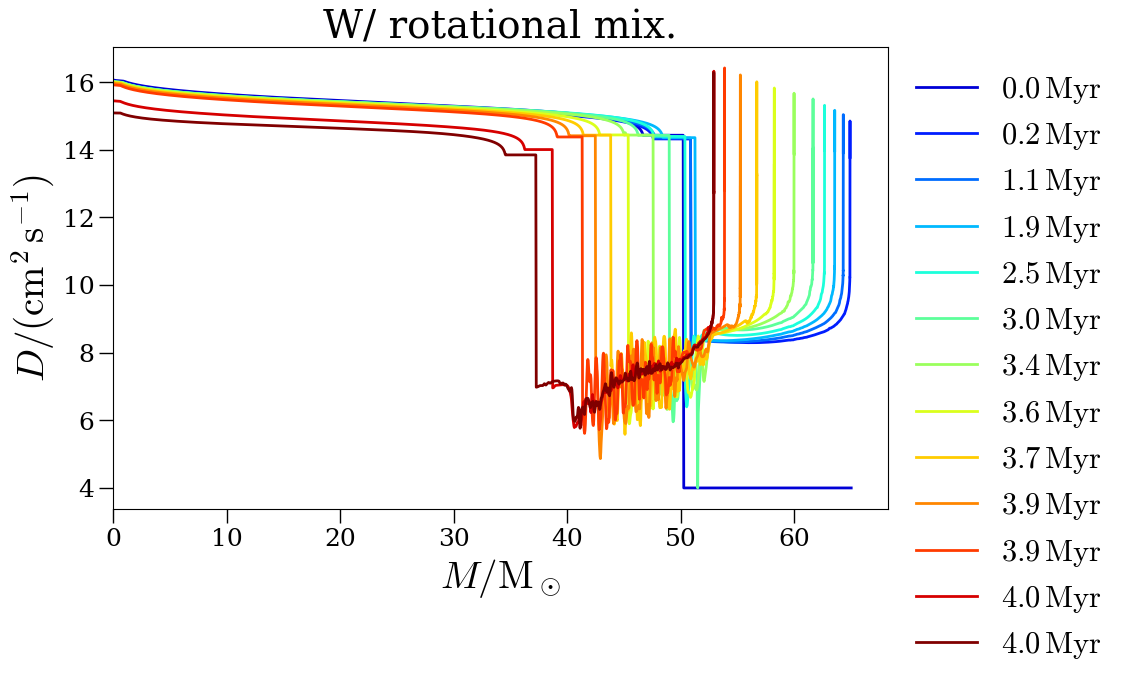

In [21]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    c = cm.jet(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.mass, prof.log_D_mix, c=c, label=f'${prof.star_age/1e6:.1f}\\,\\mathrm{{Myr}}$', lw=2)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)
    ax.set_title('W/ rotational mix.')
    ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
    ax.set_ylabel('$D/(\\mathrm{cm}^2\\,\\mathrm{s}^{-1})$')
    ax.set_xlim(0)
    
    

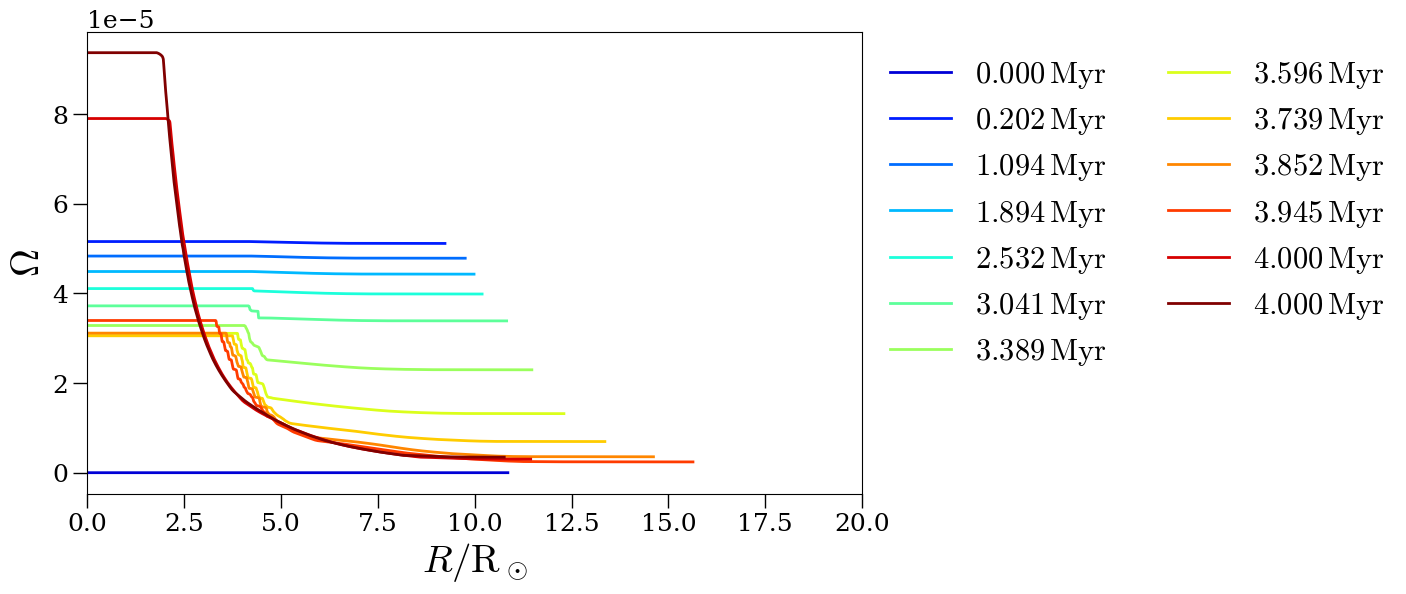

In [22]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    c = cm.jet(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.radius, prof.omega, c=c, label=f'${prof.star_age/1e6:.3f}\\,\\mathrm{{Myr}}$', lw=2)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=2)
    #ax.set_title('W/ rotational mix.')
    ax.set_xlabel('$R/\\mathrm{R}_\\odot$')
    ax.set_ylabel('$\\Omega$')
    ax.set_xlim(0, 20)
    
    

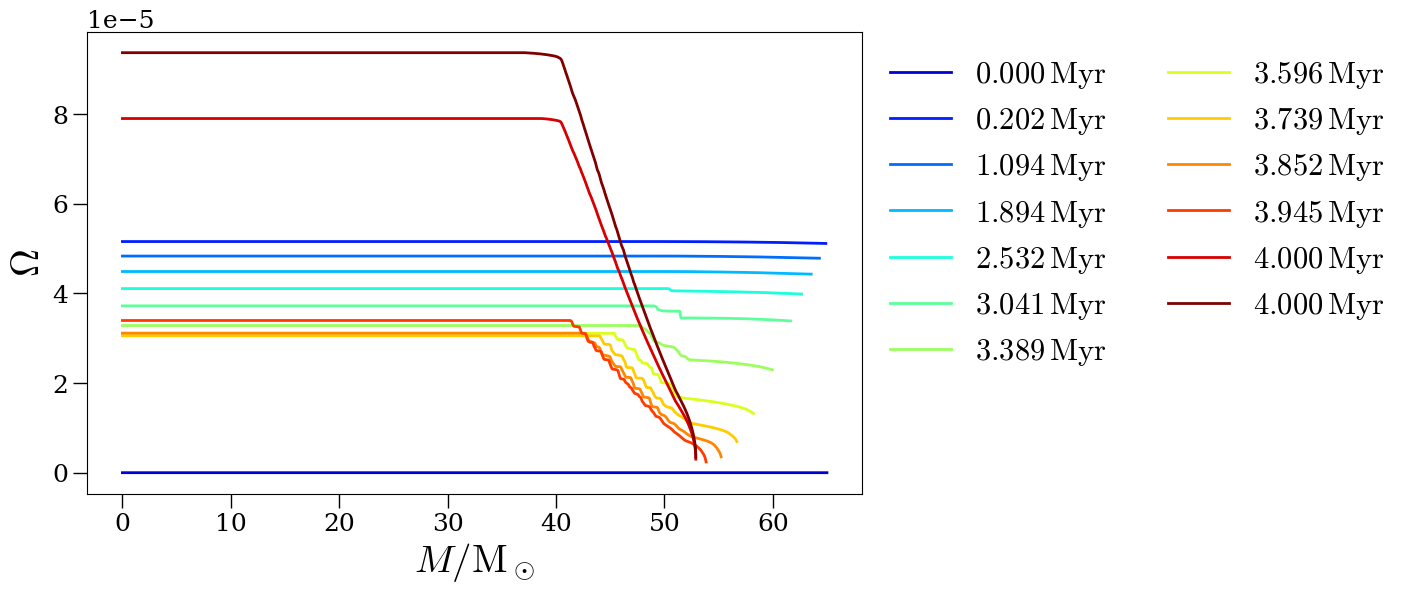

In [23]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    c = cm.jet(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.mass, prof.omega, c=c, label=f'${prof.star_age/1e6:.3f}\\,\\mathrm{{Myr}}$', lw=2)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=2)
    #ax.set_title('W/ rotational mix.')
    ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
    ax.set_ylabel('$\\Omega$')
    #ax.set_xlim(0, 20)
    
    

In [ ]:
test_case = model_dict2['65.0']['4.04']
h = mr.MesaData(str(test_case/'LOGS/history.data'))
logs  = mr.MesaLogDir(str(test_case/'LOGS'))
profile_numbers = logs.profile_numbers

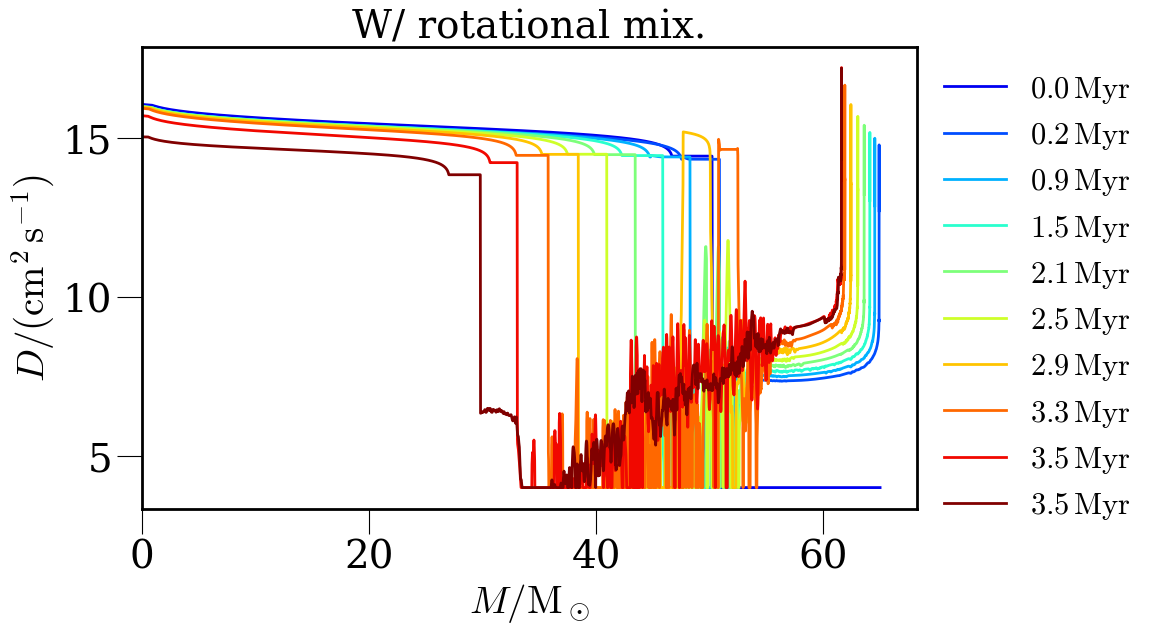

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    c = cm.jet(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.mass, prof.log_D_mix, c=c, label=f'${prof.star_age/1e6:.1f}\\,\\mathrm{{Myr}}$', lw=2)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)
    ax.set_title('W/ rotational mix.')
    ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
    ax.set_ylabel('$D/(\\mathrm{cm}^2\\,\\mathrm{s}^{-1})$')
    ax.set_xlim(0)
    
    

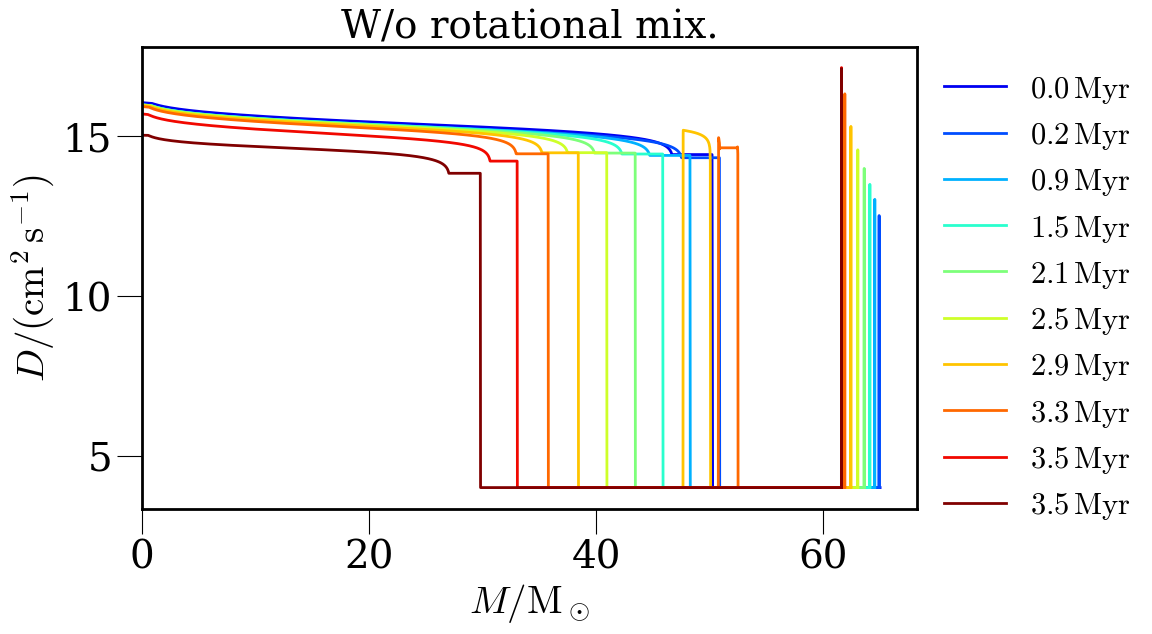

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    c = cm.jet(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.mass, prof.log_D_mix_non_rotation, c=c, label=f'${prof.star_age/1e6:.1f}\\,\\mathrm{{Myr}}$', lw=2)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)
    ax.set_title('W/o rotational mix.')
    ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
    ax.set_ylabel('$D/(\\mathrm{cm}^2\\,\\mathrm{s}^{-1})$')
    ax.set_xlim(0)
    
    

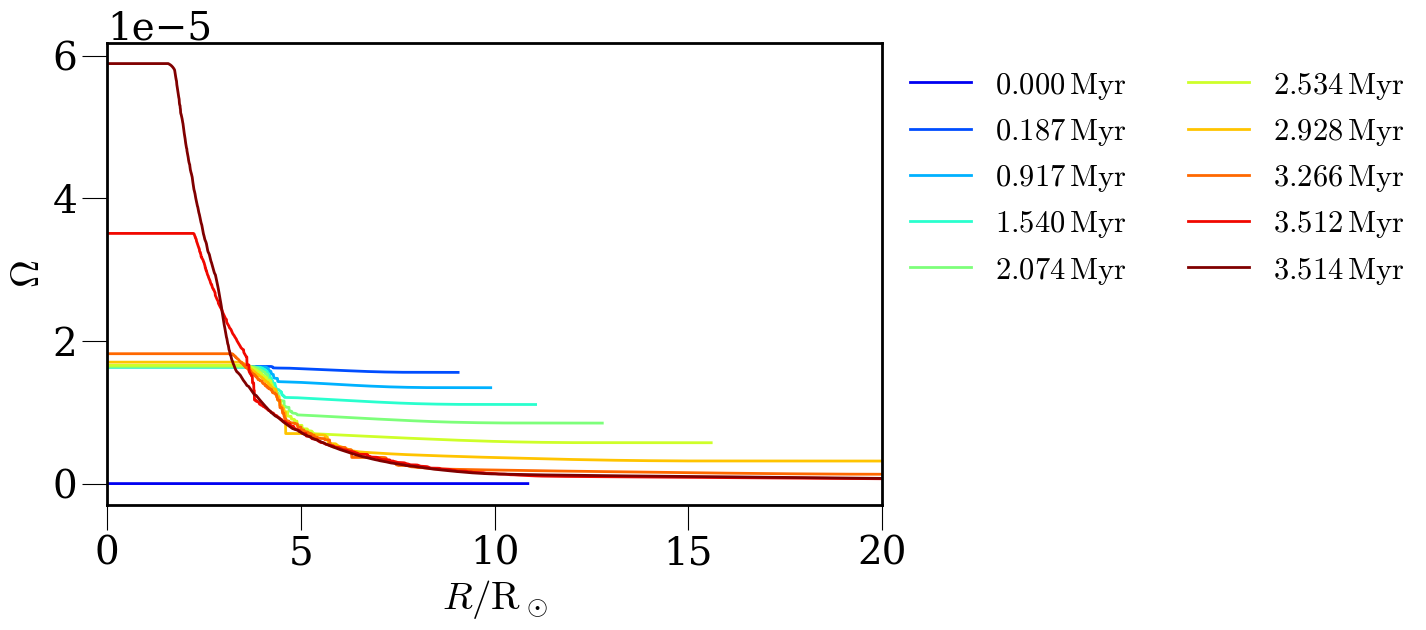

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    c = cm.jet(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.radius, prof.omega, c=c, label=f'${prof.star_age/1e6:.3f}\\,\\mathrm{{Myr}}$', lw=2)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=2)
    #ax.set_title('W/ rotational mix.')
    ax.set_xlabel('$R/\\mathrm{R}_\\odot$')
    ax.set_ylabel('$\\Omega$')
    ax.set_xlim(0, 20)
    
    

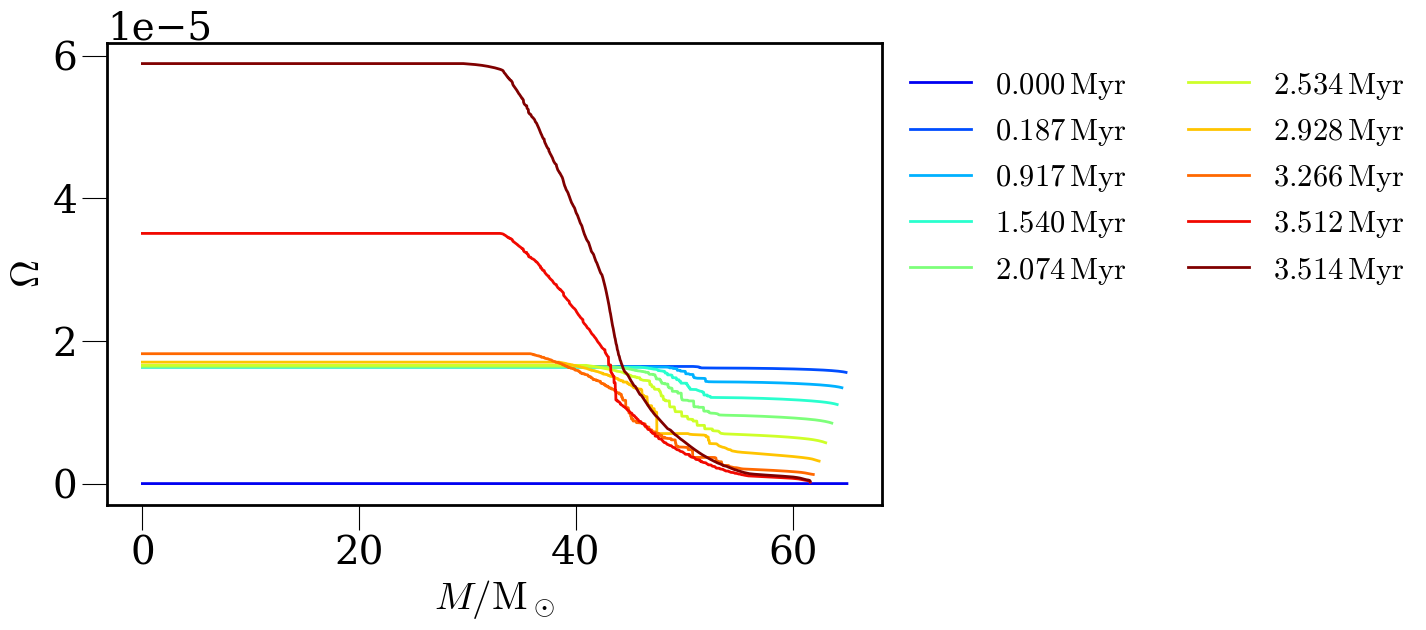

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    c = cm.jet(n/len(profile_numbers))
    prof = logs.profile_data(profile_number=n)
    ax.plot(prof.mass, prof.omega, c=c, label=f'${prof.star_age/1e6:.3f}\\,\\mathrm{{Myr}}$', lw=2)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=2)
    #ax.set_title('W/ rotational mix.')
    ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
    ax.set_ylabel('$\\Omega$')
    #ax.set_xlim(0, 20)
    
    

## Mixing timescale

In [ ]:
def tau_mix(prof):
    mix_types = prof.mixing_type
    first_overshoot_i = np.where(mix_types == 2)[0][0]

    r = prof.radius[:first_overshoot_i]
    d = 10.**prof.log_D_mix[:first_overshoot_i]
    d_nonrot = 10.**prof.log_D_mix_non_rotation[:first_overshoot_i]
    h_p = prof.pressure_scale_height[:first_overshoot_i] * u.Rsun.to(u.cm)
    dt_mix = h_p**2 / d
    dt_mix_nonrot = h_p**2 / d_nonrot

    mix_tscale = -simpson(x=r, y=dt_mix) * u.s.to(u.yr)
    mix_tscale_nonrot = -simpson(x=r, y=dt_mix_nonrot) * u.s.to(u.yr)

    return mix_tscale, mix_tscale_nonrot

In [ ]:
all_paths = [model_dict[k1][k2] for k1 in model_dict.keys() for k2 in model_dict[k1].keys()] 

/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/gridnewfix_m65_var_p_test/m6.5d+01_w1.5d-04
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/gridnewfix_m65_var_p_test/m6.5d+01_w8.2d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/gridnewfix_m65_var_p_test/m6.5d+01_w5.7d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/gridnewfix_m65_var_p_test/m6.5d+01_w4.4d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/gridnewfix_m65_var_p_test/m6.5d+01_w2.6d-05
/mnt/home/ldesa/repos/cher/mesa/sse_newmodels_test/gridnewfix_m65_var_p_test/m6.5d+01_w1.8d-05


Text(0, 0.5, '$\\tau_\\mathrm{mix}/\\mathrm{Myr}$')

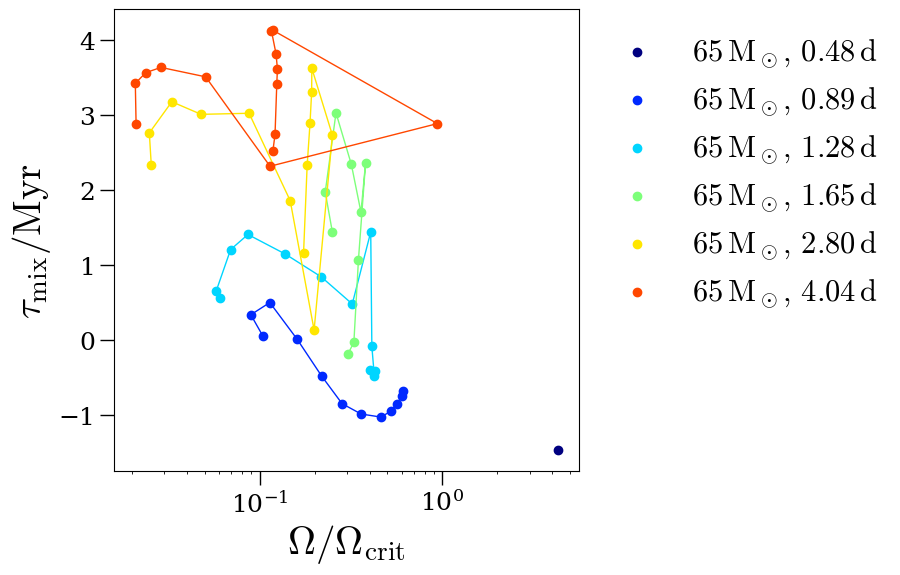

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))

_c = 0
handles = []
for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))
    p_keys = np.array(list(p_dict.keys()))[p_keys_sort]
    m = float(m_key)
    for p_key in p_keys:
        p = float(p_key)
        c = cm.jet(_c/len(all_paths))
        handles.append(ax.scatter([], [], marker='o', color=c, 
                                  label=f'${m:.0f}\\,\\mathrm{{M}}_\\odot,\\,{p:.2f}\\,\\mathrm{{d}}$'))
        p = float(p_key)
        model_path = p_dict[p_key]
        print(model_path)
        profiles = mr.MesaLogDir(model_path/'LOGS')
        plot_points = list()
        for n in profiles.profile_numbers:
            if n == 1:
                continue
            prof = profiles.profile_data(profile_number=n)
            tmix, tmix_nonrot = tau_mix(prof)
            plot_points.append([prof.omega_div_omega_crit[0], np.log10(tmix/1e6)])
        plot_points = np.array(plot_points)
        ax.plot(plot_points[:,0], plot_points[:,1], ls='-', marker='o', lw=1, color=c)
        _c += 1
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1,1))
ax.set_xscale('log')
ax.set_xlabel('$\\Omega/\\Omega_\\mathrm{crit}$')
ax.set_ylabel('$\\tau_\\mathrm{mix}/\\mathrm{Myr}$')

Text(0, 0.5, '$\\tau_\\mathrm{mix}/\\mathrm{Myr}$')

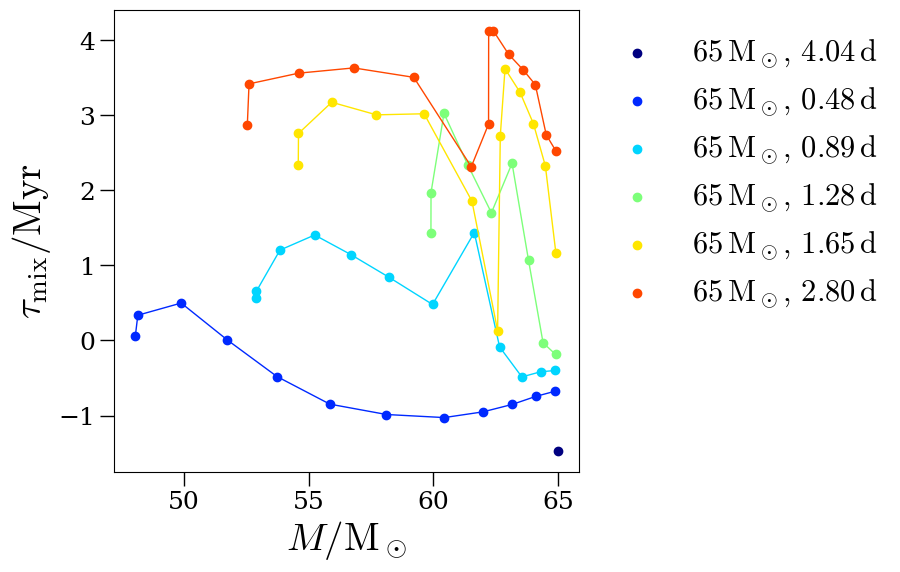

In [ ]:

fig, ax = plt.subplots(figsize=(6,6))

_c = 0
handles = []
for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))
    p_keys = np.array(list(p_dict.keys()))[p_keys_sort]
    m = float(m_key)
    for p_key in p_keys:
        c = cm.jet(_c/len(all_paths))
        handles.append(ax.scatter([], [], marker='o', color=c, 
                                  label=f'${m:.0f}\\,\\mathrm{{M}}_\\odot,\\,{p:.2f}\\,\\mathrm{{d}}$'))
        p = float(p_key)
        model_path = p_dict[p_key]
        profiles = mr.MesaLogDir(model_path/'LOGS')
        plot_points = list()
        for n in profiles.profile_numbers:
            if n == 1:
                continue
            prof = profiles.profile_data(profile_number=n)
            tmix, tmix_nonrot = tau_mix(prof)
            plot_points.append([prof.mass[0], np.log10(tmix/1e6)])
        plot_points = np.array(plot_points)
        ax.plot(plot_points[:,0], plot_points[:,1], ls='-', marker='o', lw=1, color=c)
        _c += 1
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1,1))
#ax.set_xscale('log')
ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax.set_ylabel('$\\tau_\\mathrm{mix}/\\mathrm{Myr}$')

Text(0, 0.5, '$\\tau_\\mathrm{mix}/\\mathrm{Myr}$')

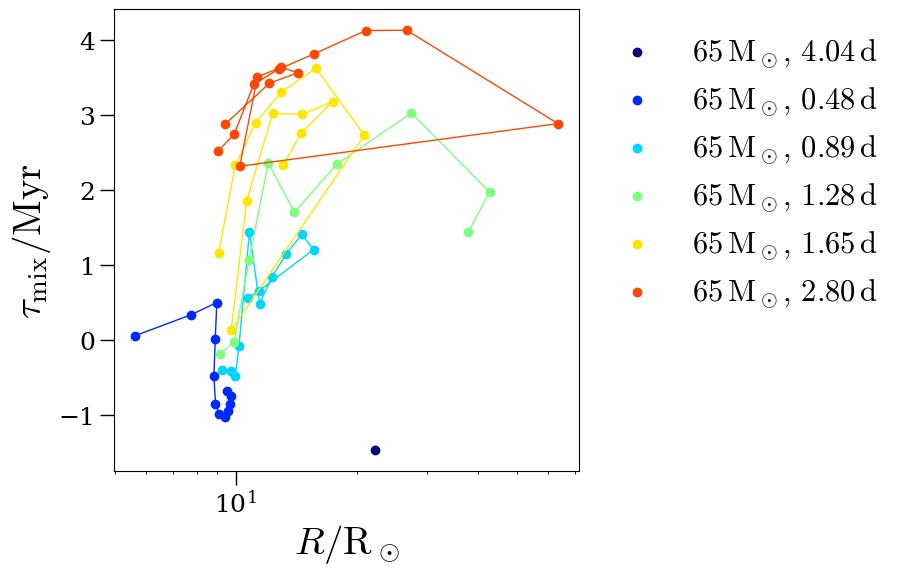

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))

_c = 0
handles = []
for m_key in model_dict.keys():
    p_dict = model_dict[m_key]
    p_keys_sort = np.argsort(np.float64(np.array(list(p_dict.keys()))))
    p_keys = np.array(list(p_dict.keys()))[p_keys_sort]
    m = float(m_key)
    for p_key in p_keys:
        c = cm.jet(_c/len(all_paths))
        handles.append(ax.scatter([], [], marker='o', color=c, 
                                  label=f'${m:.0f}\\,\\mathrm{{M}}_\\odot,\\,{p:.2f}\\,\\mathrm{{d}}$'))
        p = float(p_key)
        model_path = p_dict[p_key]
        profiles = mr.MesaLogDir(model_path/'LOGS')
        plot_points = list()
        for n in profiles.profile_numbers:
            if n == 1:
                continue
            prof = profiles.profile_data(profile_number=n)
            tmix, tmix_nonrot = tau_mix(prof)
            plot_points.append([prof.radius[0], np.log10(tmix/1e6)])
        plot_points = np.array(plot_points)
        ax.plot(plot_points[:,0], plot_points[:,1], ls='-', marker='o', lw=1, color=c)
        _c += 1
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1,1))
ax.set_xscale('log')
ax.set_xlabel('$R/\\mathrm{R}_\\odot$')
ax.set_ylabel('$\\tau_\\mathrm{mix}/\\mathrm{Myr}$')